In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys 
sys.path.append("/n/home12/binxuwang/Github/DiffusionReasoning")
from tensorboard_utils import extract_all_runs, extract_tensorboard_data_from_run, extract_last_step_summary
from rule_new_utils import infer_rule_from_sample_batch, compute_rule_statistics, infer_rule_statistics_from_sample_batch, rule_table_brief, rule_table

In [4]:
import os
import numpy as np
import pandas as pd
import torch
from os.path import join
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.autonotebook import trange, tqdm
from pprint import pprint

/tmp/ipykernel_2665249/3959933813.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


### Paths

In [5]:
tabdir = "/n/home12/binxuwang/Github/DiffusionReasoning/Tables"
# figdir = "/n/home12/binxuwang/Github/DiffusionReasoning/Figures_newrule"

GPT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven"
DiT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
SiT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/SiT/results"
SSM_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/Mamba_raven"
EDM_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"

In [6]:
figroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning"
GPTfigdir = join(figroot, "GPT2_raven")
EDMfigdir = join(figroot, "EDM_raven")
DiTfigdir = join(figroot, "DiT_raven")
SSMfigdir = join(figroot, "SSM_raven")
SiTfigdir = join(figroot, "SiT_raven")

In [7]:
import pandas as pd
# Set the maximum column width to 100 characters
pd.set_option('display.max_colwidth', 100)

In [8]:
!mkdir  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/GPT2_raven
!mkdir  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/EDM_raven
!mkdir  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/DiT_raven
!mkdir  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/SSM_raven
!mkdir  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/SiT_raven

mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/GPT2_raven’: File exists
mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/EDM_raven’: File exists
mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/DiT_raven’: File exists
mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/SSM_raven’: File exists
mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/SiT_raven’: File exists


In [9]:
figdir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_memorization_inspection"

### Util functions for Rule learning dynamics 

Function to parse the experiment string

In [10]:
import re
def extract_and_convert(string):
    """Simple function to extract pattern like stream0_16 or stream16M and convert to float 0.16 or integer 16"""
    # Pattern to match the "0_16" part and convert to float 0.16
    match1 = re.search(r'stream(\d+)_(\d+)', string)
    if match1:
        num1 = str(match1.group(1))
        num2 = str(match1.group(2))
        result = float(f"{num1}.{num2}")
        return result
    
    # Pattern to match the "16M" part and convert to integer 16
    match2 = re.search(r'stream(\d+)M', string)
    if match2:
        result = int(match2.group(1))
        return result
    
    return None

Functions to load the samples and eval stats, plot the data

In [11]:
def sweep_collect_sample(expname, exproot, prefix=None, non_prefix=None):
    assert os.path.exists(join(exproot, expname, "samples")), expname  
    # print(sorted(os.listdir(join(exproot, expname, "samples"))))
    print(f"Extracted data from {join(exproot, expname, 'samples')}")
    print(f"example file:", os.listdir(join(exproot, expname, 'samples'))[0:10])
    # raise NotImplementedError("This function is not implemented yet")
    # for files with names like 'sample_rule_eval_995000.pt' find the one with largest number
    # TODO: check and fix the prefix prompt
    epoch_nums = sorted([int(f.split(prefix)[-1].split(".pt")[0]) for f in os.listdir(join(exproot, expname,'samples')) if not (non_prefix in f)])
    eval_col = {}
    for epoch_num in tqdm(epoch_nums):
        samples_eval = torch.load(join(exproot, expname, 'samples', f"{epoch_num:07d}.pt"))
        eval_col[epoch_num] = samples_eval
    return eval_col

In [12]:
def sweep_collect_eval_data(expname, exproot, prefix=None):
    assert os.path.exists(join(exproot, expname, "samples")), expname  
    # print(sorted(os.listdir(join(exproot, expname, "samples"))))
    print(f"Extracted data from {join(exproot, expname, 'samples')}")
    print(f"example file:", os.listdir(join(exproot, expname, 'samples'))[0])
    # for files with names like 'sample_rule_eval_995000.pt' find the one with largest number
    epoch_nums = sorted([int(f.split(prefix)[-1].split(".pt")[0]) for f in os.listdir(join(exproot, expname,'samples')) if prefix in f])
    eval_col = {}
    for epoch_num in tqdm(epoch_nums):
        samples_eval = torch.load(join(exproot, expname, 'samples', f"{prefix}{epoch_num}.pt"))
        eval_col[epoch_num] = samples_eval
    return eval_col

In [13]:
def extract_rule_list_from_eval_col(eval_col, is_abinit = False):
    epoch_list = sorted(list(eval_col.keys()))
    rule_list_all = []
    consistency_all = []
    for epoch in eval_col.keys():
        if is_abinit:
            rule_list_all.append(eval_col[epoch]['rule_col_list_abinit'])
            consistency_all.append((eval_col[epoch]['C3_list_abinit'], eval_col[epoch]['C2_list_abinit']))
        else:
            rule_list_all.append(eval_col[epoch]['rule_col_list'])
            consistency_all.append((eval_col[epoch]['C3_list'], eval_col[epoch]['C2_list']))
    rule_list_all = np.array(rule_list_all, dtype=object)
    consistency_all = np.array(consistency_all, dtype=object)
    print(rule_list_all.shape, consistency_all.shape)
    return epoch_list, rule_list_all, consistency_all


def extract_rule_list_from_eval_col_Diffusion(eval_col, ):
    print("diffusion model, just fetch ab init generation")
    epoch_list = sorted(list(eval_col.keys()))
    rule_list_all = []
    consistency_all = []
    for epoch in eval_col.keys():
        rule_list_all.append(eval_col[epoch]['rule_col'])
        consistency_all.append((eval_col[epoch]['c3_list'], eval_col[epoch]['c2_list']))

    rule_list_all = np.array(rule_list_all, dtype=object)
    consistency_all = np.array(consistency_all, dtype=object)
    print(rule_list_all.shape, consistency_all.shape)
    return epoch_list, rule_list_all, consistency_all

In [14]:
def format_rule_list_to_mat(rule_list_all, consistency_all):
    """Format the collected rule_list_all and consistency_all into rule_cnt_mat, cons3_rule_cnt_mat, cons2_rule_cnt_mat.
    for plotting purposes.

    Args:
        rule_list_all: np.array, dtype object, shape=(num_epoch, num_sample, 3). 
        consistency_all: np.array, dtype object, shape=(num_epoch, 2, num_sample). 
                    where the 2nd dimension is the consistency of C3 and C2 rules corrspondingly. 

    Returns:
        rule_cnt_mat: np.array, shape=(num_epoch, 40). 
        cons3_rule_cnt_mat: np.array, shape=(num_epoch, 40). 
        cons2_rule_cnt_mat: np.array, shape=(num_epoch, 40).
    """
    epoch_num = rule_list_all.shape[0]
    rule_pool_all = []
    for i in range(epoch_num): # trange
        rule_pool = np.concatenate(list(rule_list_all[i,:,:].flatten())).astype(int)
        rule_pool_all.append(rule_pool)
    # plot the number of rules == rule_i for each generation
    rule_cnt_mat = np.zeros((epoch_num, 40))
    for i in range(epoch_num): # trange
        rule_pool = rule_pool_all[i]
        rule_uniq, counts = np.unique(rule_pool, return_counts=True)
        rule_cnt_mat[i, rule_uniq] = counts

    cons3_rule_pool_all = []
    cons2_rule_pool_all = []
    for i in range(epoch_num): # trange
        rule_pool = np.concatenate(list(consistency_all[i,0,:].flatten())).astype(int)
        cons3_rule_pool_all.append(rule_pool)
        rule_pool = np.concatenate(list(consistency_all[i,1,:].flatten())).astype(int)
        cons2_rule_pool_all.append(rule_pool)

    cons3_rule_cnt_mat = np.zeros((epoch_num, 40))
    cons2_rule_cnt_mat = np.zeros((epoch_num, 40))
    for i in range(epoch_num): # trange
        rule_pool = cons3_rule_pool_all[i]
        rule_uniq, counts = np.unique(rule_pool, return_counts=True)
        cons3_rule_cnt_mat[i, rule_uniq] = counts
        rule_pool = cons2_rule_pool_all[i]
        rule_uniq, counts = np.unique(rule_pool, return_counts=True)
        cons2_rule_cnt_mat[i, rule_uniq] = counts
    return rule_cnt_mat, cons3_rule_cnt_mat, cons2_rule_cnt_mat

In [15]:
from rule_new_utils import rule_table, relation_dict, attribute_dict
from circuit_toolkit.plot_utils import saveallforms
def visualize_indiv_rule_dynam(epoch_list, rule_mat, conv_wid=10, heldout_id=[1, 16, 20, 34, 37],
                               titlestr="Valid rule count separated by rule type", ylabel="Count", axs=None):
    # remove top and right spines from plot with plt
    plt.rcParams.update({'font.size': 12})
    if axs is None:
        figh, axs = plt.subplots(4, 10, figsize=(30, 12.5), sharex=True, sharey=True)
    else:
        figh = axs[0,0].get_figure()
    axs_f = axs.flatten()
    for i in range(40):
        ax = axs_f[i]
        # smooth the curve
        smooth_rule_cnt = np.convolve(rule_mat[:,i], np.ones(conv_wid)/conv_wid, mode='same')
        ax.plot(epoch_list, smooth_rule_cnt, alpha=0.7, )
        ax.set_title(f"R{i}: {rule_table[i]}")
        # change the font color of title to red
        if i in heldout_id:
            ax.title.set_color('red')
        if i >= 30:
            ax.set_xlabel("generation")
        if i % 10 == 0:
            ax.set_ylabel(ylabel)
    figh.suptitle(titlestr, fontsize=20)
    figh.tight_layout()
    figh.show()
    return figh, axs

In [16]:
def visualize_train_heldout_rule(epoch_list, plot_mat, heldout_id, 
                                 normalizer=None, titlestr="", 
                                 reflevel=None):#conv_wid=10, axs=None):
    heldout_mask = np.zeros((40,)).astype(bool)
    heldout_mask[heldout_id] = True
    if normalizer is not None:
        plot_mat = plot_mat / normalizer
    figh, axs = plt.subplots(1, 2, figsize=(11, 5), sharey=True)
    plt.subplot(1, 2, 1)
    plt.plot(epoch_list, plot_mat[:, ~heldout_mask], alpha=0.4)
    plt.plot(epoch_list, plot_mat[:, ~heldout_mask].mean(axis=1), color='black', linewidth=2)
    if reflevel is not None:
        plt.axhline(y=reflevel, color='r', linestyle='--')
    plt.subplot(1, 2, 2)
    plt.plot(epoch_list, plot_mat[:, heldout_mask], alpha=0.4)
    plt.plot(epoch_list, plot_mat[:, heldout_mask].mean(axis=1), color='black', linewidth=2)
    if reflevel is not None:
        plt.axhline(y=reflevel, color='r', linestyle='--')
    plt.suptitle(titlestr) # "Accuracy of C3 for each rule type"
    plt.show()
    return figh

## SiT

In [17]:
syndf_SiT = pd.read_csv(join(tabdir, "SiT_raven_tensorboard_data.csv"), index_col=0)
tb_data_col_SiT = pkl.load(open(join(tabdir, "SiT_raven_tensorboard_raw_data.pkl"), "rb"))

In [18]:
syndf_SiT.full_name

run_name
004-SiT_S_1-stream0_16M_pilot-Linear-velocity-None            004-SiT_S_1-stream0_16M_pilot-Linear-velocity-None/tensorboard_logs
005-SiT_B_1-stream0_16M_pilot-Linear-velocity-None            005-SiT_B_1-stream0_16M_pilot-Linear-velocity-None/tensorboard_logs
006-SiT_S_1-stream0_016M_all-Linear-velocity-None              006-SiT_S_1-stream0_016M_all-Linear-velocity-None/tensorboard_logs
007-SiT_S_1-stream0_16M_all-Linear-velocity-None                007-SiT_S_1-stream0_16M_all-Linear-velocity-None/tensorboard_logs
008-SiT_S_1-stream1_6M_all-Linear-velocity-None                  008-SiT_S_1-stream1_6M_all-Linear-velocity-None/tensorboard_logs
010-SiT_S_1-stream16M_all-Linear-velocity-None                    010-SiT_S_1-stream16M_all-Linear-velocity-None/tensorboard_logs
011-SiT_B_1-stream0_16M_all-Linear-velocity-None                011-SiT_B_1-stream0_16M_all-Linear-velocity-None/tensorboard_logs
011-SiT_S_1-stream16M_heldout0-Linear-velocity-None          011-SiT_S_1-stream16

### Load samples from a good model generation

In [19]:
# for expfullname in ["014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None/tensorboard_logs",]:
#                     # "017-SiT_B_1-stream0_16M_heldout0-Linear-velocity-None/tensorboard_logs"
expfullname = "013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None/tensorboard_logs"
# expfullname = "014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None/tensorboard_logs"
tb_record = tb_data_col_SiT[expfullname]
expname = expfullname.split("/tensorboard_logs")[0]
prefix = "sample_rule_eval_" #"eval_step" if "stream" in expname else "eval_epoch"
eval_col = sweep_collect_eval_data(expname, SiT_exproot, prefix=prefix)
sample_col = sweep_collect_sample(expname, SiT_exproot, non_prefix=prefix)
print("step min %d max %d, total %d saves" % (min(sample_col.keys()), max(sample_col.keys()), len(sample_col.keys())))

Extracted data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/SiT/results/013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None/samples
example file: 0155000.pt


  0%|          | 0/402 [00:00<?, ?it/s]

Extracted data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/SiT/results/013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None/samples
example file: ['0155000.pt', '0422500.pt', '0432500.pt', '0715000.pt', '0787500.pt', '0072500.pt', '0277500.pt', 'sample_rule_eval_465000.pt', 'sample_rule_eval_602500.pt', '0707500.pt']


  0%|          | 0/402 [00:00<?, ?it/s]

step min 0 max 1000000, total 402 saves


In [20]:
figdir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_memorization_inspection"
os.makedirs(figdir, exist_ok=True)
figexpdir = join(figdir, expfullname.split("/")[0])
os.makedirs(figexpdir, exist_ok=True)

In [21]:
list(eval_col[1000000])

['c3_list', 'c2_list', 'rule_col', 'c3_cnt', 'c2_cnt', 'anyvalid_cnt', 'total']

In [22]:
epoch = 1000000
C3_cnt, C2_cnt, valid_cnt, total_cnt = infer_rule_statistics_from_sample_batch(sample_col[epoch])
assert C3_cnt == eval_col[epoch]['c3_cnt']
assert C2_cnt == eval_col[epoch]['c2_cnt']
assert valid_cnt == eval_col[epoch]['anyvalid_cnt']
print("C3 fraction:", C3_cnt / total_cnt, "C2 fraction:", C2_cnt / total_cnt, "valid fraction:", valid_cnt / total_cnt / 3)

C3 fraction: 0.0126953125 C2 fraction: 0.08056640625 valid fraction: 0.4568684895833333


In [23]:
print("Test validity independence assumption")
C3_frac = C3_cnt / total_cnt
C2_frac = C2_cnt / total_cnt
valid_frac = valid_cnt / total_cnt / 3
print("C3 fraction:", C3_frac, "C3 assuming independent valid", valid_frac ** 3)
print("C2 & C3 fraction:", C3_frac + C2_frac, "C2 & C3 assuming independent valid", valid_frac ** 2)

Test validity independence assumption
C3 fraction: 0.0126953125 C3 assuming independent valid 0.09536161925212513
C2 & C3 fraction: 0.09326171875 C2 & C3 assuming independent valid 0.20872881677415633


### Load the training set

In [24]:
!echo $STORE_DIR/Datasets/RPM_dataset/RPM1000k 

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/RPM_dataset/RPM1000k


In [25]:
import einops
train_attr_fn = "attr_all_1000k.pt" 
data_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/RPM_dataset/RPM1000k"
def get_RAVEN_dataset(data_root, train_attr_fn, n_classes=40, cmb_per_class=4000, heldout_ids=(), cmb_offset=0):
    train_attrs = torch.load(f'{data_root}/{train_attr_fn}') # [35, 10000, 3, 9, 3]
    attr_img_tsr = einops.rearrange(train_attrs,  'cls (B R) p (H W) attr -> cls B attr (R H) (p W)', H=3,W=3,p=3,R=3,attr=3,)
    max_default_cmb = attr_img_tsr.shape[1]
    if cmb_per_class > max_default_cmb:
        raise ValueError(f'cmb_per_class should be less than {max_default_cmb}')
    train_cls_msk = torch.ones(n_classes, dtype=bool)
    for heldout_id in heldout_ids:
        train_cls_msk[heldout_id] = False
    X = attr_img_tsr[:, cmb_offset:cmb_offset + cmb_per_class]
    y = torch.arange(0, n_classes).unsqueeze(1).expand(n_classes, cmb_per_class).to(int)
    X = einops.rearrange(X[train_cls_msk, :], 'cls B attr H W -> (cls B) attr H W')
    y = einops.rearrange(y[train_cls_msk, :], 'cls B -> (cls B)')
    return X, y

In [26]:
def check_fraction_train_set(gen_sample_rows_list, train_X_row_set):
    cnt = 0
    for i, row in enumerate(gen_sample_rows_list):
        if row in train_X_row_set:
            cnt += 1
            # print(i, row)
    total = len(gen_sample_rows_list)
    frac = cnt / total
    return cnt, frac

def check_fraction_train_set_idxlist(gen_sample_rows_list, train_X_row_set):
    cnt = 0
    idx_list = []
    for i, row in enumerate(gen_sample_rows_list):
        if row in train_X_row_set:
            cnt += 1
            idx_list.append(i)
            # print(i, row)
    total = len(gen_sample_rows_list)
    frac = cnt / total
    return cnt, frac, idx_list

In [28]:
train_tsr_X, train_tsr_y = get_RAVEN_dataset(data_root, train_attr_fn, n_classes=40, cmb_per_class=400, heldout_ids=())

In [29]:
train_tsr_X_rows = einops.rearrange(train_tsr_X, 'B attr (R h) W -> (B R) (attr h W)', R=3, h=3, W=9).numpy().astype(int)
print(train_tsr_X_rows.shape)
train_X_row_set = set([tuple(train_tsr_X_rows[i]) for i in range(train_tsr_X_rows.shape[0])])

(48000, 81)


In [30]:
train_tsr_X_panels = einops.rearrange(train_tsr_X, 'B attr (R h) (P w) -> (B R P) (attr h w)', R=3, h=3, P=3, w=3).numpy().astype(int)
print(train_tsr_X_panels.shape)
train_X_panel_set = set([tuple(train_tsr_X_panels[i]) for i in range(train_tsr_X_panels.shape[0])])

(144000, 27)


In [31]:
gen_sample_rows = einops.rearrange(sample_col[1000000].round().int(), 'B attr (R h) W -> (B R) (attr h W)', R=3, h=3, W=9).numpy().astype(int)
gen_sample_rows_list = [tuple(gen_sample_rows[i]) for i in range(gen_sample_rows.shape[0])]

In [32]:
gen_sample_panels = einops.rearrange(sample_col[1000000].round().int(), 'B attr (R h) (P w) -> (B R P) (attr h w)', R=3, h=3, P=3, w=3).numpy().astype(int)
gen_sample_panels_list = [tuple(gen_sample_panels[i]) for i in range(gen_sample_panels.shape[0])]

### Systematic eval memorization at different level

In [33]:
def extract_row_mat_set(sample_tsr, outtype=set):
    """Expecting 
    sample_tsr: torch.Tensor, shape=(B, attr, H, W), usually (B, 3, 9, 9)
    """
    sample_tsr = sample_tsr.round().int()
    sample_rows = einops.rearrange(sample_tsr, 'B attr (R h) W -> (B R) (attr h W)', R=3, h=3, W=9).numpy().astype(int)
    assert sample_rows.shape[1] == 81, sample_rows.shape
    sample_row_set = outtype([tuple(sample_rows[i]) for i in range(sample_rows.shape[0])])
    return sample_rows, sample_row_set


def extract_panel_mat_set(sample_tsr, outtype=set):
    """Expecting 
    sample_tsr: torch.Tensor, shape=(B, attr, H, W), usually (B, 3, 9, 9)
    """
    sample_tsr = sample_tsr.round().int()
    sample_panels = einops.rearrange(sample_tsr, 'B attr (R h) (P w) -> (B R P) (attr h w)', R=3, h=3, P=3, w=3).numpy().astype(int)
    assert sample_panels.shape[1] == 27, sample_panels.shape
    sample_panel_set = outtype([tuple(sample_panels[i]) for i in range(sample_panels.shape[0])])
    return sample_panels, sample_panel_set


def extract_attr_row_mat_set(sample_tsr, attr_id, outtype=set):
    """Expecting 
    sample_tsr: torch.Tensor, shape=(B, attr, H, W), usually (B, 3, 9, 9)
    """
    sample_tsr = sample_tsr.round().int()
    sample_rows = einops.rearrange(sample_tsr[:, attr_id:attr_id+1], 'B attr (R h) W -> (B R) (attr h W)', R=3, h=3, W=9).numpy().astype(int)
    assert sample_rows.shape[1] == 27, sample_rows.shape
    sample_row_set = outtype([tuple(sample_rows[i]) for i in range(sample_rows.shape[0])])
    return sample_rows, sample_row_set


def extract_attr_panel_mat_set(sample_tsr, attr_id, outtype=set):
    """Expecting 
    sample_tsr: torch.Tensor, shape=(B, attr, H, W), usually (B, 3, 9, 9)
    """
    sample_tsr = sample_tsr.round().int()
    sample_panels = einops.rearrange(sample_tsr[:, attr_id:attr_id+1], 'B attr (R h) (P w) -> (B R P) (attr h w)', R=3, h=3, P=3, w=3).numpy().astype(int)
    assert sample_panels.shape[1] == 9, sample_panels.shape
    sample_panel_set = outtype([tuple(sample_panels[i]) for i in range(sample_panels.shape[0])])
    return sample_panels, sample_panel_set


In [34]:
train_tsr_X_rows, train_X_row_set = extract_row_mat_set(train_tsr_X)
train_tsr_X_panels, train_X_panel_set = extract_panel_mat_set(train_tsr_X)
train_X_row_set_attr_col = {}
train_X_panel_set_attr_col = {}
for attr_id in range(3):
    train_tsr_X_rows_attr, train_X_row_set_attr = extract_attr_row_mat_set(train_tsr_X, attr_id)
    train_tsr_X_panels_attr, train_X_panel_set_attr = extract_attr_panel_mat_set(train_tsr_X, attr_id)
    train_X_row_set_attr_col[attr_id] = train_X_row_set_attr
    train_X_panel_set_attr_col[attr_id] = train_X_panel_set_attr

In [35]:
_, gen_sample_rows_list = extract_row_mat_set(sample_col[1000000], outtype=list)
_, gen_sample_panels_list = extract_panel_mat_set(sample_col[1000000], outtype=list)
cnt, frac = check_fraction_train_set(gen_sample_rows_list, train_X_row_set)
print(f"full row: {cnt}, {frac}")
cnt, frac = check_fraction_train_set(gen_sample_panels_list, train_X_panel_set)
print(f"full panel: {cnt}, {frac}")
for attri in range(3):
    _, gen_sample_panels_list_attr = extract_attr_panel_mat_set(sample_col[1000000], attri, outtype=list)
    _, gen_sample_rows_list_attr = extract_attr_row_mat_set(sample_col[1000000], attri, outtype=list)
    cnt, frac = check_fraction_train_set(gen_sample_rows_list_attr, train_X_row_set_attr_col[attri])
    print(f"attr{attri} row: {cnt}, {frac}")
    cnt, frac = check_fraction_train_set(gen_sample_panels_list_attr, train_X_panel_set_attr_col[attri])
    print(f"attr{attri} panel: {cnt}, {frac}")

full row: 33, 0.00537109375
full panel: 1627, 0.08827039930555555
attr0 row: 73, 0.011881510416666666
attr0 panel: 10418, 0.5652126736111112
attr1 row: 51, 0.00830078125
attr1 panel: 10877, 0.5901150173611112
attr2 row: 58, 0.009440104166666666
attr2 panel: 10378, 0.5630425347222222


In [36]:
def eval_memorization_all_level_sample_tsr(sample_tsr, ctrl_X_row_set, ctrl_X_panel_set, ctrl_X_row_set_attr_col, ctrl_X_panel_set_attr_col):
    """
    Process the sample_col[epoch] and update statistics.

    Parameters:
    sample_col_epoch: The sample column for the given epoch.
    ctrl_X_row_set: Control set for rows.
    ctrl_X_panel_set: Control set for panels.
    ctrl_X_row_set_attr_col: Control set for row attributes.
    ctrl_X_panel_set_attr_col: Control set for panel attributes.

    Returns:
    stats_entry: A dictionary containing the statistics.
    """
    stats_entry = {}

    _, gen_sample_rows_list = extract_row_mat_set(sample_tsr, outtype=list)
    _, gen_sample_panels_list = extract_panel_mat_set(sample_tsr, outtype=list)
    rowcnt, rowfrac = check_fraction_train_set(gen_sample_rows_list, ctrl_X_row_set)
    pancnt, panfrac = check_fraction_train_set(gen_sample_panels_list, ctrl_X_panel_set)
    stats_entry.update({"mem_rowcnt": rowcnt, "mem_rowfrac": rowfrac, "mem_pancnt": pancnt, "mem_panfrac": panfrac})

    for attri in range(3):
        _, gen_sample_panels_list_attr = extract_attr_panel_mat_set(sample_tsr, attri, outtype=list)
        _, gen_sample_rows_list_attr = extract_attr_row_mat_set(sample_tsr, attri, outtype=list)
        attr_rowcnt, attr_rowfrac = check_fraction_train_set(gen_sample_rows_list_attr, ctrl_X_row_set_attr_col[attri])
        attr_pancnt, attr_panfrac = check_fraction_train_set(gen_sample_panels_list_attr, ctrl_X_panel_set_attr_col[attri])
        stats_entry.update({f"mem_attr{attri}_rowcnt": attr_rowcnt, f"mem_attr{attri}_rowfrac": attr_rowfrac,
                            f"mem_attr{attri}_pancnt": attr_pancnt, f"mem_attr{attri}_panfrac": attr_panfrac})

    return stats_entry

In [37]:
mem_stats_col = []
for epoch in tqdm(sample_col.keys()):
    stats_entry = {"epoch": epoch}
    C3_cnt, C2_cnt, valid_cnt, total_cnt = eval_col[epoch]['c3_cnt'], eval_col[epoch]['c2_cnt'], eval_col[epoch]['anyvalid_cnt'], eval_col[epoch]['total']
    stats_entry.update({"C3": C3_cnt, "C2": C2_cnt, "valid": valid_cnt, "total": total_cnt})
    stats_entry.update(eval_memorization_all_level_sample_tsr(sample_col[epoch], train_X_row_set, train_X_panel_set, train_X_row_set_attr_col, train_X_panel_set_attr_col))
    mem_stats_col.append(stats_entry)
    
mem_stats_df = pd.DataFrame(mem_stats_col)
mem_stats_df.to_csv(join(figexpdir, "memorization_levels_dynamics_stats.csv"))

  0%|          | 0/402 [00:00<?, ?it/s]

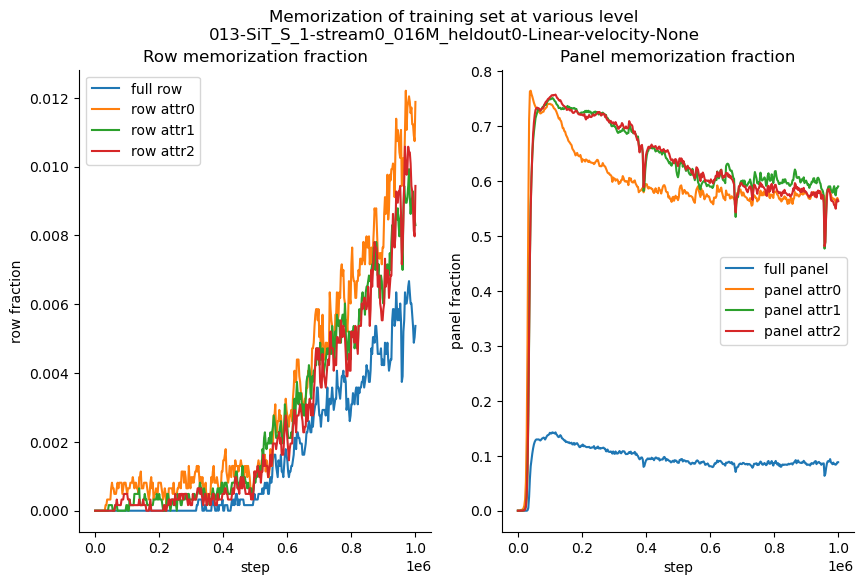

In [38]:
figh, axs = plt.subplots(1, 2, figsize=(10, 6))
plt.sca(axs[0])
sns.lineplot(data=mem_stats_df, x="epoch", y="mem_rowfrac", label="full row")   
sns.lineplot(data=mem_stats_df, x="epoch", y="mem_attr0_rowfrac", label="row attr0")
sns.lineplot(data=mem_stats_df, x="epoch", y="mem_attr1_rowfrac", label="row attr1")
sns.lineplot(data=mem_stats_df, x="epoch", y="mem_attr2_rowfrac", label="row attr2")
plt.title("Row memorization fraction")
plt.ylabel("row fraction")
plt.xlabel("step")
plt.legend()
plt.sca(axs[1])
sns.lineplot(data=mem_stats_df, x="epoch", y="mem_panfrac", label="full panel")
sns.lineplot(data=mem_stats_df, x="epoch", y="mem_attr0_panfrac", label="panel attr0")
sns.lineplot(data=mem_stats_df, x="epoch", y="mem_attr1_panfrac", label="panel attr1")
sns.lineplot(data=mem_stats_df, x="epoch", y="mem_attr2_panfrac", label="panel attr2")
plt.title("Panel memorization fraction")
plt.ylabel("panel fraction")
plt.xlabel("step")
plt.legend()
plt.suptitle(f"Memorization of training set at various level\n{expname}")
saveallforms(figexpdir, "memorization_levels_dynamics", figh)
plt.show()

### Control case: control samples / control training set


#### Control samples

In [47]:
ctrl_mem_levels = []
for cmb_offset in trange(20000, 40000, 2000):
    ctrl_sample_tsr_X, ctrl_sample_tsr_y = get_RAVEN_dataset(data_root, train_attr_fn, n_classes=40, cmb_per_class=1000, heldout_ids=(), cmb_offset=cmb_offset)
    ctrl_mem_level = eval_memorization_all_level_sample_tsr(ctrl_sample_tsr_X, train_X_row_set, train_X_panel_set, train_X_row_set_attr_col, train_X_panel_set_attr_col)
        #ctrl_sample_tsr_X, ctrl_X_row_set, ctrl_X_panel_set, ctrl_X_row_set_attr_col, ctrl_X_panel_set_attr_col)
    # pprint(ctrl_mem_level)
    ctrl_mem_levels.append(ctrl_mem_level)
ctrl_mem_levels_df = pd.DataFrame(ctrl_mem_levels)

  0%|          | 0/10 [00:00<?, ?it/s]

In [48]:
# only show columns with "frac" in the name
ctrl_mem_levels_df.aggregate(["mean", "sem"]).filter(like="frac", axis=1)

,mem_rowfrac,mem_panfrac,mem_attr0_rowfrac,mem_attr0_panfrac,mem_attr1_rowfrac,mem_attr1_panfrac,mem_attr2_rowfrac,mem_attr2_panfrac
mean,0.0,0.139552,0.001138,0.757225,0.000198,0.762621,0.000184,0.762755
sem,0.0,0.000158,0.000020,0.000355,0.000011,0.000274,0.000018,0.000380


In [52]:
ctrl_mem_levels = []
for cmb_offset in trange(20000, 30000, 3000):
    ctrl_sample_tsr_X, ctrl_sample_tsr_y = get_RAVEN_dataset(data_root, train_attr_fn, n_classes=40, cmb_per_class=2048, heldout_ids=(), cmb_offset=cmb_offset)
    ctrl_mem_level = eval_memorization_all_level_sample_tsr(ctrl_sample_tsr_X, train_X_row_set, train_X_panel_set, train_X_row_set_attr_col, train_X_panel_set_attr_col)
        #ctrl_sample_tsr_X, ctrl_X_row_set, ctrl_X_panel_set, ctrl_X_row_set_attr_col, ctrl_X_panel_set_attr_col)
    # pprint(ctrl_mem_level)
    ctrl_mem_levels.append(ctrl_mem_level)
ctrl_mem_levels_df = pd.DataFrame(ctrl_mem_levels)

  0%|          | 0/4 [00:00<?, ?it/s]

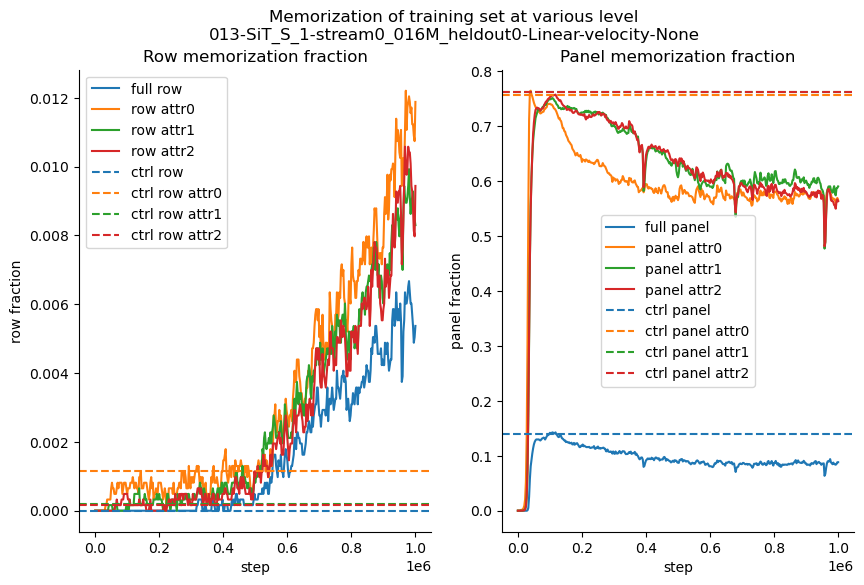

In [53]:
figh, axs = plt.subplots(1, 2, figsize=(10, 6))
plt.sca(axs[0])
sns.lineplot(data=mem_stats_df, x="epoch", y="mem_rowfrac", label="full row")   
sns.lineplot(data=mem_stats_df, x="epoch", y="mem_attr0_rowfrac", label="row attr0")
sns.lineplot(data=mem_stats_df, x="epoch", y="mem_attr1_rowfrac", label="row attr1")
sns.lineplot(data=mem_stats_df, x="epoch", y="mem_attr2_rowfrac", label="row attr2")
plt.axhline(y=ctrl_mem_levels_df["mem_rowfrac"].mean(), linestyle='--', label="ctrl row", color='C0')
plt.axhline(y=ctrl_mem_levels_df["mem_attr0_rowfrac"].mean(), linestyle='--', label="ctrl row attr0", color='C1')
plt.axhline(y=ctrl_mem_levels_df["mem_attr1_rowfrac"].mean(), linestyle='--', label="ctrl row attr1", color='C2')
plt.axhline(y=ctrl_mem_levels_df["mem_attr2_rowfrac"].mean(), linestyle='--', label="ctrl row attr2", color='C3')
plt.title("Row memorization fraction")
plt.ylabel("row fraction")
plt.xlabel("step")
plt.legend()
plt.sca(axs[1])
sns.lineplot(data=mem_stats_df, x="epoch", y="mem_panfrac", label="full panel")
sns.lineplot(data=mem_stats_df, x="epoch", y="mem_attr0_panfrac", label="panel attr0")
sns.lineplot(data=mem_stats_df, x="epoch", y="mem_attr1_panfrac", label="panel attr1")
sns.lineplot(data=mem_stats_df, x="epoch", y="mem_attr2_panfrac", label="panel attr2")
plt.axhline(y=ctrl_mem_levels_df["mem_panfrac"].mean(), linestyle='--', label="ctrl panel", color='C0')
plt.axhline(y=ctrl_mem_levels_df["mem_attr0_panfrac"].mean(), linestyle='--', label="ctrl panel attr0", color='C1')
plt.axhline(y=ctrl_mem_levels_df["mem_attr1_panfrac"].mean(), linestyle='--', label="ctrl panel attr1", color='C2')
plt.axhline(y=ctrl_mem_levels_df["mem_attr2_panfrac"].mean(), linestyle='--', label="ctrl panel attr2", color='C3')
plt.title("Panel memorization fraction")
plt.ylabel("panel fraction")
plt.xlabel("step")
plt.legend()
plt.suptitle(f"Memorization of training set at various level\n{expname}")
saveallforms(figexpdir, "memorization_levels_dynamics_ref", figh)
plt.show()

#### Controlled training sample

In [42]:
ctrl_tsr_X, ctrl_tsr_y = get_RAVEN_dataset(data_root, train_attr_fn, n_classes=40, cmb_per_class=400, heldout_ids=(), cmb_offset=8000)
ctrl_sample_tsr_X, ctrl_sample_tsr_y = get_RAVEN_dataset(data_root, train_attr_fn, n_classes=40, cmb_per_class=2048, heldout_ids=(), cmb_offset=40000)

In [43]:
_, ctrl_X_row_set = extract_row_mat_set(ctrl_tsr_X)
_, ctrl_X_panel_set = extract_panel_mat_set(ctrl_tsr_X)
ctrl_X_row_set_attr_col = {}
ctrl_X_panel_set_attr_col = {}
for attr_id in range(3):
    _, ctrl_X_row_set_attr = extract_attr_row_mat_set(ctrl_tsr_X, attr_id)
    _, ctrl_X_panel_set_attr = extract_attr_panel_mat_set(ctrl_tsr_X, attr_id)
    ctrl_X_row_set_attr_col[attr_id] = ctrl_X_row_set_attr
    ctrl_X_panel_set_attr_col[attr_id] = ctrl_X_panel_set_attr

In [44]:
# positive control
ctrl_sample_tsr_X, ctrl_sample_tsr_y = get_RAVEN_dataset(data_root, train_attr_fn, n_classes=40, cmb_per_class=2048, heldout_ids=(), cmb_offset=8000)
eval_memorization_all_level_sample_tsr(ctrl_sample_tsr_X, ctrl_X_row_set, ctrl_X_panel_set, ctrl_X_row_set_attr_col, ctrl_X_panel_set_attr_col)

{'mem_rowcnt': 48000,
 'mem_rowfrac': 0.1953125,
 'mem_pancnt': 227060,
 'mem_panfrac': 0.3079698350694444,
 'mem_attr0_rowcnt': 48217,
 'mem_attr0_rowfrac': 0.19619547526041667,
 'mem_attr0_pancnt': 593917,
 'mem_attr0_panfrac': 0.8055514865451389,
 'mem_attr1_rowcnt': 48041,
 'mem_attr1_rowfrac': 0.19547932942708332,
 'mem_attr1_pancnt': 596746,
 'mem_attr1_panfrac': 0.8093885633680555,
 'mem_attr2_rowcnt': 48040,
 'mem_attr2_rowfrac': 0.19547526041666666,
 'mem_attr2_pancnt': 596495,
 'mem_attr2_panfrac': 0.8090481228298612}

In [45]:
mem_stats_ctrl_col = []
for epoch in tqdm(sample_col.keys()):
    stats_entry = {"epoch": epoch}
    stats_add = eval_memorization_all_level_sample_tsr(sample_col[epoch], ctrl_X_row_set, ctrl_X_panel_set, ctrl_X_row_set_attr_col, ctrl_X_panel_set_attr_col)
    stats_entry.update(stats_add)
    mem_stats_ctrl_col.append(stats_entry)
    
mem_stats_ctrl_df = pd.DataFrame(mem_stats_ctrl_col)

  0%|          | 0/402 [00:00<?, ?it/s]

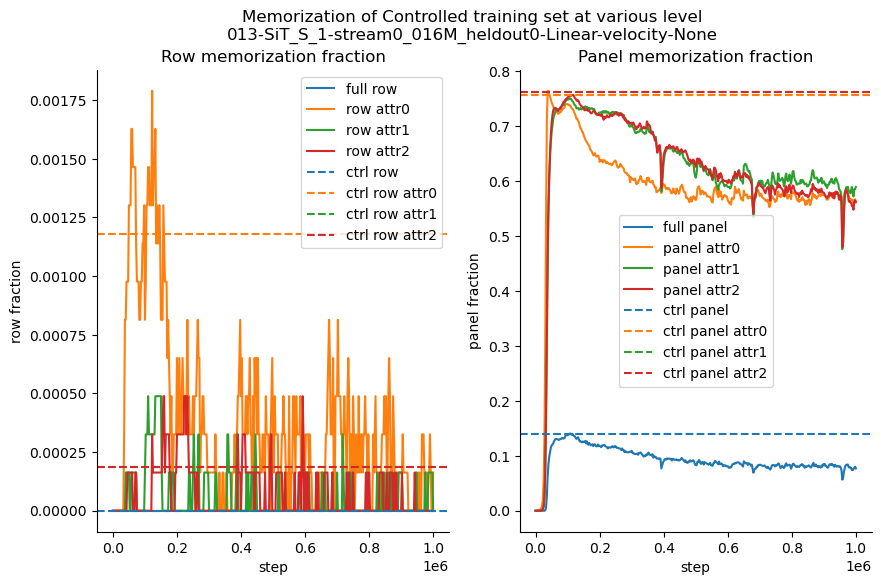

In [46]:
figh, axs = plt.subplots(1, 2, figsize=(10, 6))
plt.sca(axs[0])
sns.lineplot(data=mem_stats_ctrl_df, x="epoch", y="mem_rowfrac", label="full row")   
sns.lineplot(data=mem_stats_ctrl_df, x="epoch", y="mem_attr0_rowfrac", label="row attr0")
sns.lineplot(data=mem_stats_ctrl_df, x="epoch", y="mem_attr1_rowfrac", label="row attr1")
sns.lineplot(data=mem_stats_ctrl_df, x="epoch", y="mem_attr2_rowfrac", label="row attr2")
plt.axhline(y=ctrl_mem_levels_df["mem_rowfrac"].mean(), linestyle='--', label="ctrl row", color='C0')
plt.axhline(y=ctrl_mem_levels_df["mem_attr0_rowfrac"].mean(), linestyle='--', label="ctrl row attr0", color='C1')
plt.axhline(y=ctrl_mem_levels_df["mem_attr1_rowfrac"].mean(), linestyle='--', label="ctrl row attr1", color='C2')
plt.axhline(y=ctrl_mem_levels_df["mem_attr2_rowfrac"].mean(), linestyle='--', label="ctrl row attr2", color='C3')
plt.title("Row memorization fraction")
plt.ylabel("row fraction")
plt.xlabel("step")
plt.legend()
plt.sca(axs[1])
sns.lineplot(data=mem_stats_ctrl_df, x="epoch", y="mem_panfrac", label="full panel")
sns.lineplot(data=mem_stats_ctrl_df, x="epoch", y="mem_attr0_panfrac", label="panel attr0")
sns.lineplot(data=mem_stats_ctrl_df, x="epoch", y="mem_attr1_panfrac", label="panel attr1")
sns.lineplot(data=mem_stats_ctrl_df, x="epoch", y="mem_attr2_panfrac", label="panel attr2")
plt.axhline(y=ctrl_mem_levels_df["mem_panfrac"].mean(), linestyle='--', label="ctrl panel", color='C0')
plt.axhline(y=ctrl_mem_levels_df["mem_attr0_panfrac"].mean(), linestyle='--', label="ctrl panel attr0", color='C1')
plt.axhline(y=ctrl_mem_levels_df["mem_attr1_panfrac"].mean(), linestyle='--', label="ctrl panel attr1", color='C2')
plt.axhline(y=ctrl_mem_levels_df["mem_attr2_panfrac"].mean(), linestyle='--', label="ctrl panel attr2", color='C3')
plt.title("Panel memorization fraction")
plt.ylabel("panel fraction")
plt.xlabel("step")
plt.legend()
plt.suptitle(f"Memorization of Controlled training set at various level\n{expname}")
saveallforms(figexpdir, "memorization_levels_dynamics_ctrltrain_ref", figh)
plt.show()

In [50]:
mem_stats_ctrl_df

,epoch,mem_rowcnt,mem_rowfrac,mem_pancnt,mem_panfrac,mem_attr0_rowcnt,mem_attr0_rowfrac,mem_attr0_pancnt,mem_attr0_panfrac,mem_attr1_rowcnt,mem_attr1_rowfrac,mem_attr1_pancnt,mem_attr1_panfrac,mem_attr2_rowcnt,mem_attr2_rowfrac,mem_attr2_pancnt,mem_attr2_panfrac
0,0,0,0.0,0,0.000000,0,0.000000,2,0.000109,0,0.000000,0,0.000000,0,0.0,0,0.000000
1,1,0,0.0,0,0.000000,0,0.000000,2,0.000109,0,0.000000,0,0.000000,0,0.0,0,0.000000
2,2500,0,0.0,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000
3,5000,0,0.0,0,0.000000,0,0.000000,2,0.000109,0,0.000000,0,0.000000,0,0.0,0,0.000000
4,7500,0,0.0,0,0.000000,0,0.000000,8,0.000434,0,0.000000,0,0.000000,0,0.0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,990000,0,0.0,1361,0.073839,2,0.000326,10435,0.566135,1,0.000163,10634,0.576931,0,0.0,10207,0.553765
398,992500,0,0.0,1398,0.075846,1,0.000163,10265,0.556912,1,0.000163,10544,0.572049,0,0.0,10101,0.548014
399,995000,0,0.0,1440,0.078125,0,0.000000,10372,0.562717,1,0.000163,10783,0.585015,0,0.0,10375,0.562880
400,997500,0,0.0,1480,0.080295,0,0.000000,10451,0.567003,1,0.000163,10794,0.585612,0,0.0,10417,0.565158


## Where (spatially & class wide) does the model memorize?

### Whole panel level (generated samples)

In [54]:
_, gen_sample_panels_list = extract_panel_mat_set(sample_col[1000000], outtype=list)
pancnt, panfrac, idxlist = check_fraction_train_set_idxlist(gen_sample_panels_list, train_X_panel_set)
sample_total = len(sample_col[1000000])
row_total = sample_total * 3
panel_total = len(gen_sample_panels_list)
assert panel_total == sample_total * 9 

Examining co-occurance structure of memorized panel

In [55]:
panel_pos = (np.array(idxlist) % 3)
panel_row_idx = np.array(idxlist) // 3
panel_row_pos = panel_row_idx % 3
uniq_rowidx, mempan_cnt_in_row = np.unique(panel_row_idx, return_counts=True)
nonmem_row_N = row_total - len(uniq_rowidx)

panel_samp_pos = (np.array(idxlist) % 9)
panel_samp_idx = np.array(idxlist) // 9
uniq_sampidx, mempan_cnt_in_samp = np.unique(panel_samp_idx, return_counts=True)
nonmem_samp_N = sample_total - len(uniq_sampidx)

In [56]:
( 2048 - len(uniq_sampidx) )/ 2048

0.55322265625

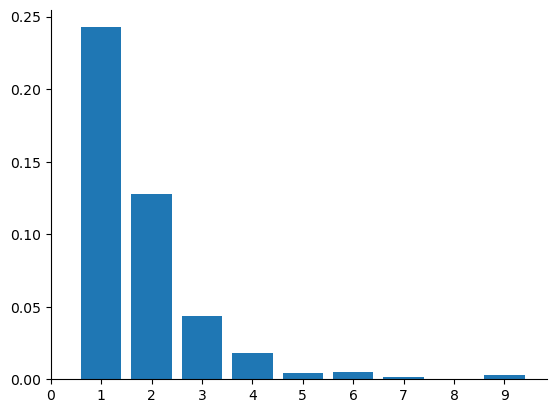

In [57]:
uniq_cnt_in_samp, sample_cnt_per_mempan_cnt = np.unique(mempan_cnt_in_samp, return_counts=True)
plt.bar(uniq_cnt_in_samp, sample_cnt_per_mempan_cnt / sample_total)
plt.xticks(np.arange(0, 10))
plt.show()

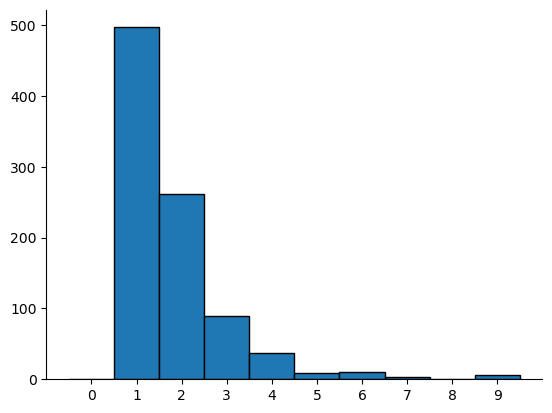

In [58]:
plt.hist(mempan_cnt_in_samp, bins=np.arange(0, 11)-0.5, align='mid', edgecolor='black')
plt.xticks(np.arange(0, 10))
plt.show()

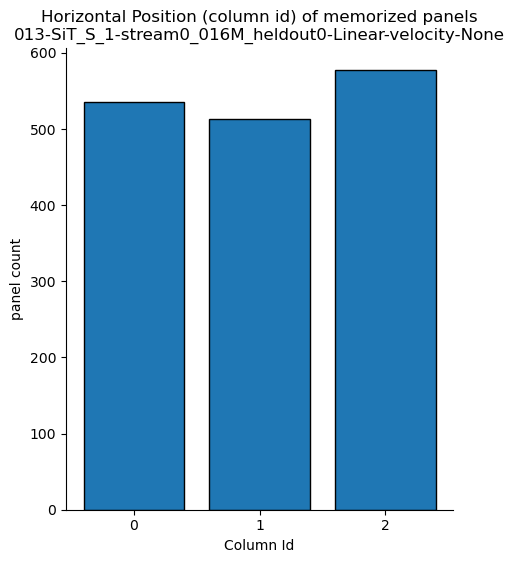

In [59]:
# uniqpos, mempan_cnt_in_pos = np.unique(panel_pos, return_counts=True)
plt.figure(figsize=(5, 6))
plt.hist(panel_pos, bins=np.arange(4)-0.5, rwidth=0.8, align='mid', edgecolor='black')
plt.xticks(np.arange(0,3))
plt.ylabel("panel count")
plt.xlabel("Column Id")
plt.title(f"Horizontal Position (column id) of memorized panels\n{expname}")
plt.show()

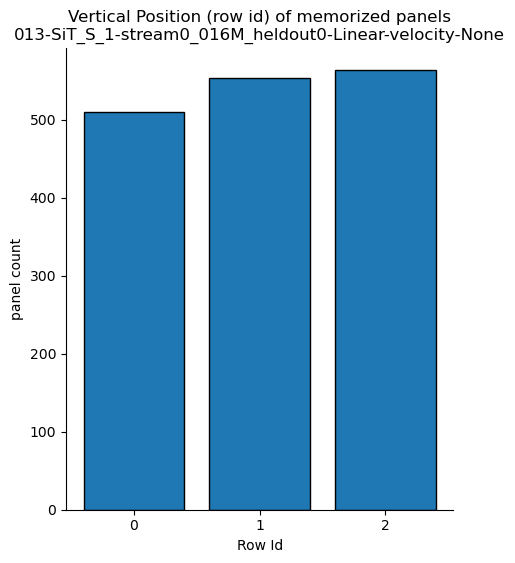

In [60]:
# uniqpos, mempan_cnt_in_pos = np.unique(panel_pos, return_counts=True)
plt.figure(figsize=(5, 6))
plt.hist(panel_row_pos, bins=np.arange(4)-0.5, rwidth=0.8, align='mid', edgecolor='black')
plt.xticks(np.arange(0,3))
plt.ylabel("panel count")
plt.xlabel("Row Id")
plt.title(f"Vertical Position (row id) of memorized panels\n{expname}")
# plt.title(f"# of memorized panels in the same row\n{expname}")
plt.show()

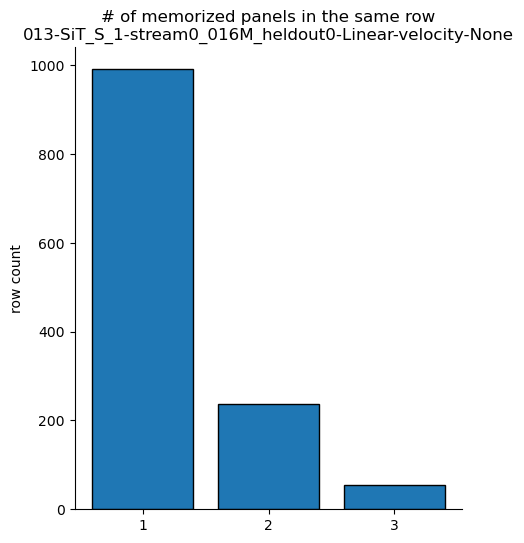

In [62]:
plt.figure(figsize=(5, 6))
plt.hist(mempan_cnt_in_row, bins=np.arange(4)+0.5, rwidth=0.8, align='mid', edgecolor='black')
plt.xticks(np.arange(1,4))
plt.ylabel("row count")
plt.title(f"# of memorized panels in the same row\n{expname}")
plt.show()

### Joint distribution of memorization

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_binary_patterns_with_connections(counts, binary_patterns=None, text="count", ax=None):
    # Generate all possible combinations of 3D binary patterns
    binary_patterns_all = np.array(list(itertools.product([False, True], repeat=3)))
    if binary_patterns is None:
        binary_patterns = np.array(list(itertools.product([False, True], repeat=3)))

    # Define new coordinates for each of the 8 binary patterns to avoid overlap
    new_coords = {
        (False, False, False): (0, 0),
        (False, False, True): (1, 0),
        (False, True, False): (0, 1),
        (False, True, True): (1, 1),
        (True, False, False): (0.5, 0.5),
        (True, False, True): (1.5, 0.5),
        (True, True, False): (0.5, 1.5),
        (True, True, True): (1.5, 1.5)
    }

    # Extract new x and y coordinates based on the mapping
    x_coords = np.array([new_coords[tuple(pattern)][0] for pattern in binary_patterns])
    y_coords = np.array([new_coords[tuple(pattern)][1] for pattern in binary_patterns])
    x_coords_all = np.array([new_coords[tuple(pattern)][0] for pattern in binary_patterns_all])
    y_coords_all = np.array([new_coords[tuple(pattern)][1] for pattern in binary_patterns_all])
    # Define adjacency pairs based on binary patterns
    adjacency_pairs = [
        (0, 1), (0, 2), (1, 3), (2, 3), # connections for False, False, False
        (4, 5), (4, 6), (5, 7), (6, 7), # connections for True, False, False
        (0, 4), (1, 5), (2, 6), (3, 7)  # connections between True and False in the first dimension
    ]
    # Plot the scatter plot with circle markers and connecting lines
    if ax is None:
        figh = plt.figure(figsize=(6, 6))
        ax = figh.add_subplot(111)
    else:
        figh = ax.figure
        plt.sca(ax)
    # Plot lines connecting adjacent points
    for pair in adjacency_pairs:
        plt.plot([x_coords_all[pair[0]], x_coords_all[pair[1]]],
                 [y_coords_all[pair[0]], y_coords_all[pair[1]]], 
                 color='gray', linestyle='-', linewidth=1)
    # Plot the points
    if text == "count":
        plt.scatter(x_coords, y_coords, s=counts, alpha=0.6, color='blue', marker='o')
    elif text == "freq":
        plt.scatter(x_coords, y_coords, s=counts / counts.sum() * 10000, alpha=0.6, color='blue', marker='o')
    # Adding labels
    for i in range(len(counts)):
        pattern_str = ''.join(['T' if x else 'F' for x in binary_patterns[i]])
        if text == "count":
            plt.text(x_coords[i], y_coords[i], f"{pattern_str}\n{counts[i]}", fontsize=16, ha='right')
        elif text == "freq":
            plt.text(x_coords[i], y_coords[i], f"{pattern_str}\n{counts[i] / counts.sum():.3f}", fontsize=16, ha='right')
        
    plt.title('Scatter Plot of Binary Patterns with Connections')
    plt.axis("equal")
    plt.axis("off")
    plt.tight_layout()
    plt.xlim(-0.5, 2.)
    plt.ylim(-0.5, 2.)
    # plt.show()
    # plt.xlabel('Redesigned X Coordinate')
    # plt.ylabel('Redesigned Y Coordinate')
    # plt.grid(True)
    return figh
# Example usage
# counts = np.array([3305, 253, 103, 289, 59, 196, 370, 1569])
# plot_binary_patterns_with_connections(counts);

In [64]:
_, gen_sample_panels_list = extract_panel_mat_set(sample_col[1000000], outtype=list)
pancnt, panfrac, idxlist = check_fraction_train_set_idxlist(gen_sample_panels_list, train_X_panel_set)
sample_total = len(sample_col[1000000])
row_total = sample_total * 3
panel_total = len(gen_sample_panels_list)
assert panel_total == sample_total * 9 

In [65]:
panel_mem_binary_vec = np.zeros((panel_total, ), dtype=bool)
panel_mem_binary_vec[idxlist] = True
panel_mem_bin_row_mat = panel_mem_binary_vec.reshape((row_total, 3))
panel_mem_bin_sample_mat = panel_mem_binary_vec.reshape((sample_total, 9))

In [66]:
np.unique(panel_mem_bin_row_mat, axis=0, return_counts=True) # the joint distribution of memorization in the same row. 

(array([[False, False, False],
        [False, False,  True],
        [False,  True, False],
        [False,  True,  True],
        [ True, False, False],
        [ True, False,  True],
        [ True,  True, False],
        [ True,  True,  True]]),
 array([4863,  369,  304,   72,  317,   82,   82,   55]))

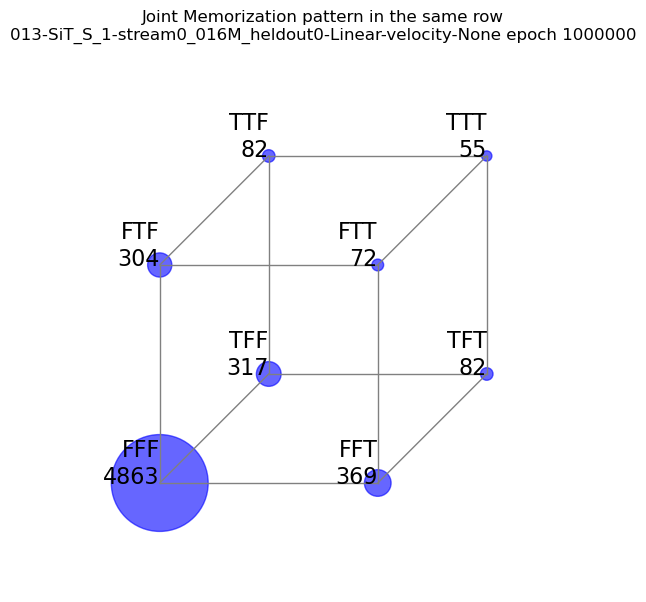

In [67]:
bin_pattern, counts = np.unique(panel_mem_bin_row_mat, axis=0, return_counts=True) # the joint distribution of memorization in the same row. 
figh = plot_binary_patterns_with_connections(counts, binary_patterns=bin_pattern)
figh.gca().set_title(f"Joint Memorization pattern in the same row\n{expname} epoch 1000000")
saveallforms(figexpdir, "memorization_row_joint_cnt_cube_final_epoch", figh)
figh.show()

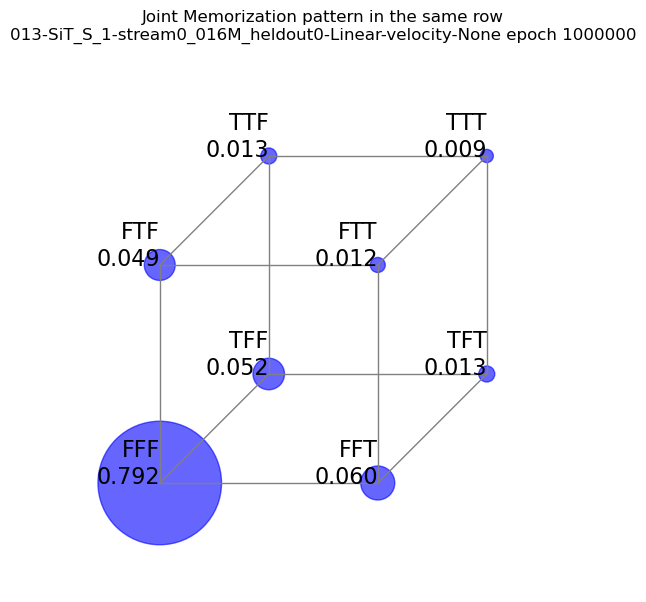

In [68]:
bin_pattern, counts = np.unique(panel_mem_bin_row_mat, axis=0, return_counts=True) # the joint distribution of memorization in the same row. 
figh = plot_binary_patterns_with_connections(counts, binary_patterns=bin_pattern, text="freq")
figh.gca().set_title(f"Joint Memorization pattern in the same row\n{expname} epoch 1000000")
saveallforms(figexpdir, "memorization_row_joint_freq_cube_final_epoch", figh)
figh.show()

In [69]:
marginal_rate = panel_mem_bin_row_mat.astype(float).mean()
ctrl_cnts = np.zeros((8, ), dtype=int)
for i, pattern in enumerate(bin_pattern):
    ctrl_cnts[i] = marginal_rate ** sum(pattern) * (1 - marginal_rate) ** (3 - sum(pattern)) * row_total

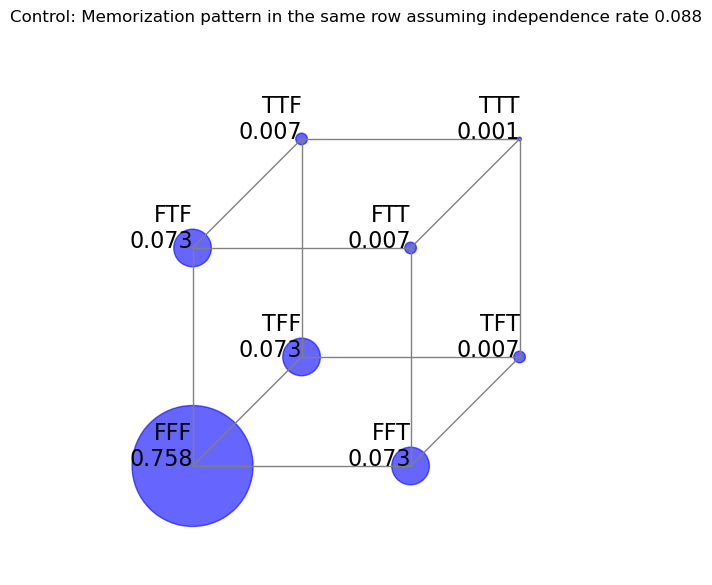

In [70]:
figh = plot_binary_patterns_with_connections(ctrl_cnts, binary_patterns=bin_pattern, text="freq")
figh.gca().set_title(f"Control: Memorization pattern in the same row assuming independence rate {marginal_rate:.3f}")
saveallforms(figexpdir, "control_memorization_row_joint_independence", figh)
figh.show()

In [71]:
bin_pattern, counts = np.unique(panel_mem_bin_row_mat, axis=0, return_counts=True)

In [72]:
np.unique(panel_mem_bin_sample_mat, axis=0, return_counts=True) # the joint distribution of memorization in the same sample. 

(array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False,  True],
        [False, False, False, ..., False,  True, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]),
 array([1133,   59,   49,   14,   57,   12,   10,    5,   58,   11,    2,
           3,   11,    3,   56,    6,    6,    1,    2,    3,    1,   12,
           1,    2,   47,    3,    7,    4,    1,    5,    1,   12,    2,
           1,    1,   14,    4,    2,    1,    2,    2,    1,    1,    1,
          58,    9,    7,    1,    9,    3,    1,    1,   11,    1,    2,
           1,    1,    1,    1,    1,    1,    7,    1,    1,    1,    1,
           1,    1,    1,   56,    8,    4,    1,    7,    1,    1,    2,
           2,    1,    7,    1,    1,    2,    1,    1,    5,    1,    1,
           1,    1,    1,    1,    1,    2,    3,  

### Memorization Joint distribution of individual rules 


In [73]:
step_list = list(sample_col.keys())

In [74]:
step_list = list(sample_col.keys())
gen_samples = [ sample_col[step]  for  step  in  step_list[-1:-10:-1] ]
gen_samples = torch.concat(gen_samples, dim=0)

_, gen_sample_panels_list = extract_panel_mat_set(gen_samples, outtype=list)
pancnt, panfrac, idxlist = check_fraction_train_set_idxlist(gen_sample_panels_list, train_X_panel_set)
sample_total = len(gen_samples)
row_total = sample_total * 3
panel_total = len(gen_sample_panels_list)
assert panel_total == sample_total * 9 

In [75]:
# construct the binary vector and matrix of memorization
panel_mem_binary_vec = np.zeros((panel_total, ), dtype=bool)
panel_mem_binary_vec[idxlist] = True
panel_mem_bin_row_mat = panel_mem_binary_vec.reshape((row_total, 3))
panel_mem_bin_sample_mat = panel_mem_binary_vec.reshape((sample_total, 9))

In [76]:
# check rules of the generated samples
C3_list, C2_list, rule_col = infer_rule_from_sample_batch(gen_samples)

In [77]:
rule_list_vec = sum(rule_col, [])

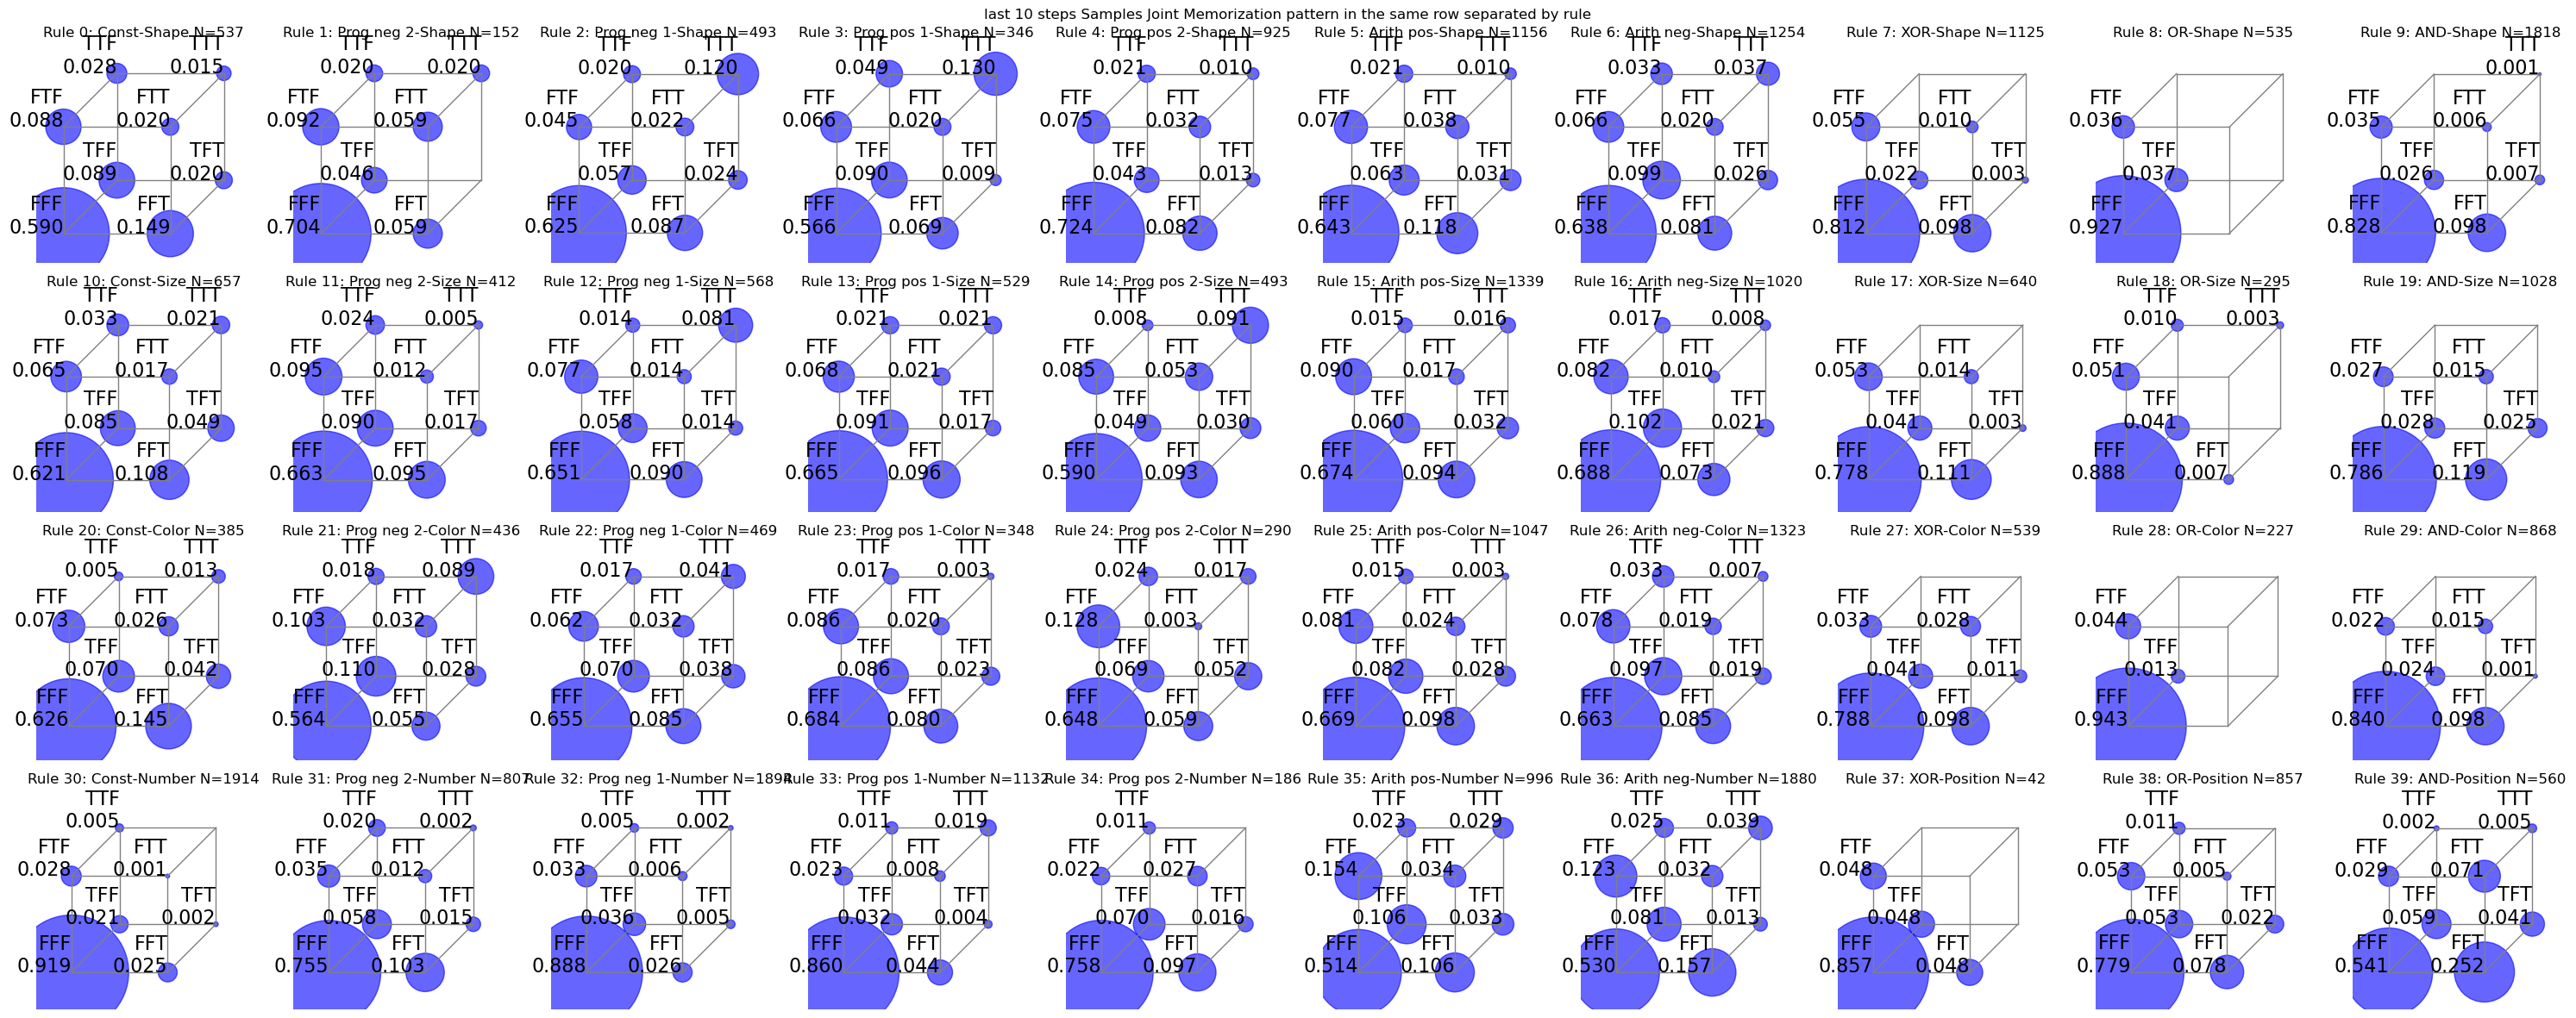

In [78]:
figh, axs = plt.subplots(4, 10, figsize=(30, 12))
axs = axs.flatten()
for rule_id in range(40):
    ax = axs[rule_id]
    row_mask = np.array([rule_id in rule_list_vec[i] for i in range(len(rule_list_vec))], dtype=bool)
    bin_pattern, counts = np.unique(panel_mem_bin_row_mat[(row_mask), :], 
                                    axis=0, return_counts=True) # the joint distribution of memorization in the same row. 
    plot_binary_patterns_with_connections(counts, binary_patterns=bin_pattern, text="freq", ax=ax)
    ax.set_title(f"Rule {rule_id}: {rule_table_brief[rule_id]} N={row_mask.sum()}")
plt.suptitle("last 10 steps Samples Joint Memorization pattern in the same row separated by rule")
plt.tight_layout()
saveallforms(figexpdir, "memorization_row_joint_freq_rule_seperated_last10steps", figh)
plt.show()

### Check the rasterization order

In [42]:
np.array(gen_sample_panels_list[0]).reshape(3,3,3)

array([[[-1,  5,  5],
        [-1, -1, -1],
        [ 5, -1,  5]],

       [[-1,  0,  0],
        [-1, -1, -1],
        [ 0, -1,  0]],

       [[-1,  4,  4],
        [-1, -1, -1],
        [ 4, -1,  4]]])

In [41]:
np.array(gen_sample_panels_list[1]).reshape(3,3,3)

array([[[ 3, -1,  3],
        [-1, -1, -1],
        [ 3, -1,  3]],

       [[ 2, -1,  2],
        [-1, -1, -1],
        [ 2, -1,  2]],

       [[ 4, -1,  4],
        [-1, -1, -1],
        [ 4, -1,  4]]])

In [43]:
np.array(gen_sample_panels_list[2]).reshape(3,3,3)

array([[[-1, -1, -1],
        [ 6, -1,  6],
        [-1, -1,  6]],

       [[-1, -1, -1],
        [ 7, -1,  7],
        [-1, -1,  7]],

       [[-1, -1, -1],
        [ 0, -1,  0],
        [-1, -1,  0]]])

In [40]:
np.array(gen_sample_rows_list[:1][0]).reshape(3,3,9)

array([[[-1,  5,  5,  3, -1,  3, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1,  6, -1,  6],
        [ 5, -1,  5,  3, -1,  3, -1, -1,  6]],

       [[-1,  0,  0,  2, -1,  2, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1,  7, -1,  7],
        [ 0, -1,  0,  2, -1,  2, -1, -1,  7]],

       [[-1,  4,  4,  4, -1,  4, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1,  0, -1,  0],
        [ 4, -1,  4,  4, -1,  4, -1, -1,  0]]])

In [93]:
ctrl_sample_tsr_X_tmp, ctrl_sample_tsr_y_tmp = get_RAVEN_dataset(data_root, train_attr_fn, n_classes=40, cmb_per_class=4000, heldout_ids=(), cmb_offset=80000)

In [95]:
sample_panels_tmp, sample_panel_set_tmp = extract_panel_mat_set(ctrl_sample_tsr_X_tmp, outtype=set)

In [97]:
len(sample_panel_set_tmp) / len(sample_panels_tmp)

0.7168277777777777

### Controlled memorization spatial location

In [79]:
ctrl_sample_tsr_X_sm, ctrl_sample_tsr_y_sm = get_RAVEN_dataset(data_root, train_attr_fn, n_classes=40, cmb_per_class=500, heldout_ids=(), cmb_offset=40000)

In [80]:
_, ctrl_samp_panel_list = extract_panel_mat_set(ctrl_sample_tsr_X_sm, outtype=list)
pancnt, panfrac, idxlist = check_fraction_train_set_idxlist(ctrl_samp_panel_list, train_X_panel_set)
panel_total = len(ctrl_samp_panel_list)
sample_total = len(ctrl_sample_tsr_X_sm)
row_total = sample_total * 3
assert panel_total == sample_total * 9

In [81]:
# construct the binary vector and matrix of memorization
panel_mem_binary_vec = np.zeros((panel_total, ), dtype=bool)
panel_mem_binary_vec[idxlist] = True
panel_mem_bin_row_mat = panel_mem_binary_vec.reshape((row_total, 3))
panel_mem_bin_sample_mat = panel_mem_binary_vec.reshape((sample_total, 9))

In [82]:
row_label_y_vec = ctrl_sample_tsr_y_sm[:,None].repeat(1, 3,).reshape(-1)
row_label_y_vec.shape

torch.Size([60000])

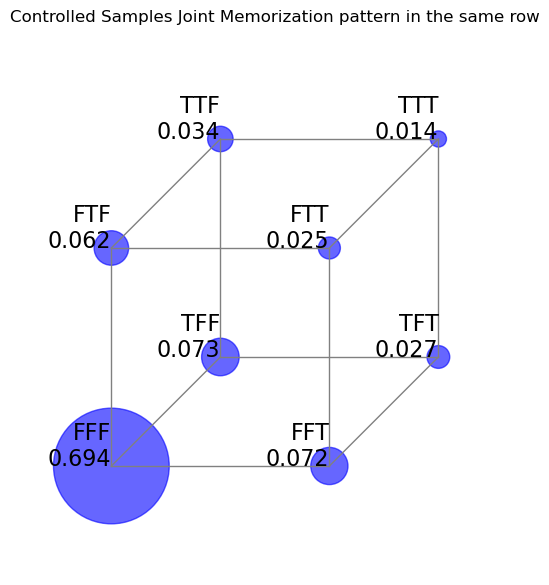

In [83]:
bin_pattern, counts = np.unique(panel_mem_bin_row_mat, axis=0, return_counts=True) # the joint distribution of memorization in the same row. 
figh = plot_binary_patterns_with_connections(counts, binary_patterns=bin_pattern, text="freq")
figh.gca().set_title("Controlled Samples Joint Memorization pattern in the same row")
figh.show()

In [84]:
panel_pos = (np.array(idxlist) % 3)
panel_row_idx = np.array(idxlist) // 3
panel_row_pos = panel_row_idx % 3
uniq_rowidx, mempan_cnt_in_row = np.unique(panel_row_idx, return_counts=True)

panel_samp_pos = (np.array(idxlist) % 9)
panel_samp_idx = np.array(idxlist) // 9
uniq_sampidx, mempan_cnt_in_samp = np.unique(panel_samp_idx, return_counts=True)

(array([0.000e+00, 4.644e+03, 3.777e+03, 2.150e+03, 1.014e+03, 3.540e+02,
        8.300e+01, 2.000e+01, 3.000e+00, 0.000e+00]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5]),
 <BarContainer object of 10 artists>)

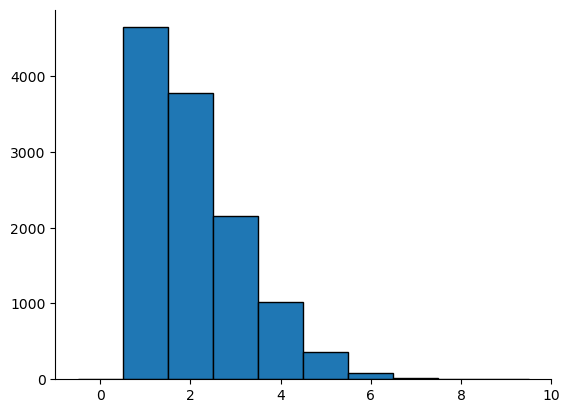

In [85]:
plt.hist(mempan_cnt_in_samp, bins=np.arange(11)-0.5, edgecolor='black')

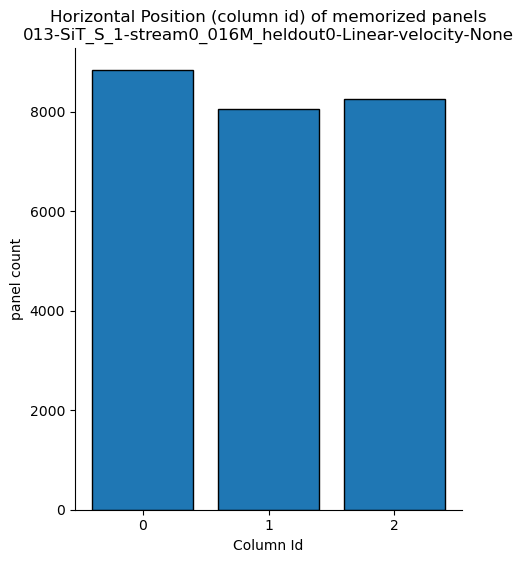

In [86]:
# uniqpos, mempan_cnt_in_pos = np.unique(panel_pos, return_counts=True)
plt.figure(figsize=(5, 6))
plt.hist(panel_pos, bins=np.arange(4)-0.5, rwidth=0.8, align='mid', edgecolor='black')
plt.xticks(np.arange(0,3))
plt.ylabel("panel count")
plt.xlabel("Column Id")
plt.title(f"Horizontal Position (column id) of memorized panels\n{expname}")
plt.show()

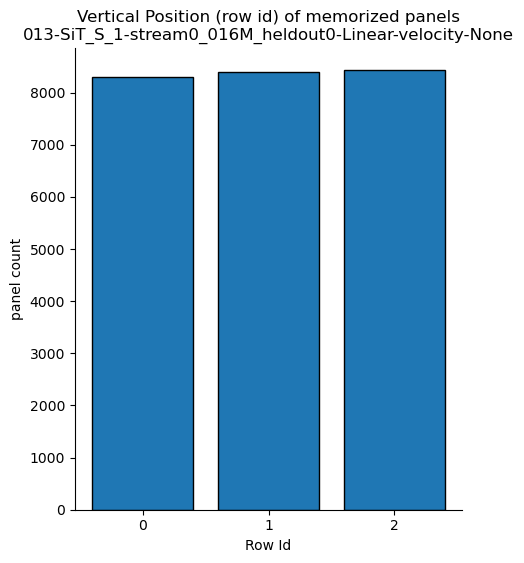

In [87]:
# uniqpos, mempan_cnt_in_pos = np.unique(panel_pos, return_counts=True)
plt.figure(figsize=(5, 6))
plt.hist(panel_row_pos, bins=np.arange(4)-0.5, rwidth=0.8, align='mid', edgecolor='black')
plt.xticks(np.arange(0,3))
plt.ylabel("panel count")
plt.xlabel("Row Id")
plt.title(f"Vertical Position (row id) of memorized panels\n{expname}")
# plt.title(f"# of memorized panels in the same row\n{expname}")
plt.show()

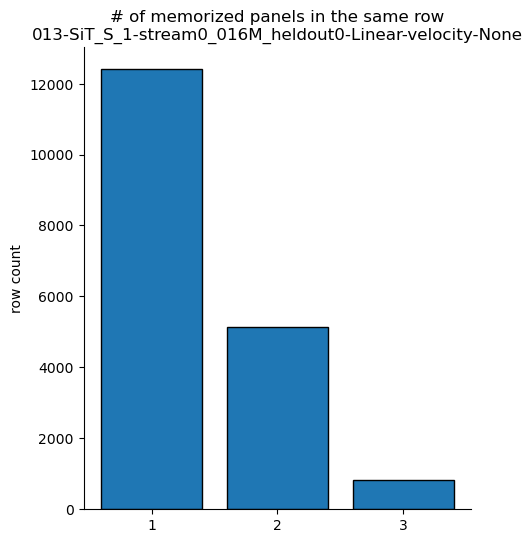

In [88]:
plt.figure(figsize=(5, 6))
plt.hist(mempan_cnt_in_row, bins=np.arange(4)+0.5, rwidth=0.8, align='mid', edgecolor='black')
plt.xticks(np.arange(1,4))
plt.ylabel("row count")
plt.title(f"# of memorized panels in the same row\n{expname}")
plt.show()

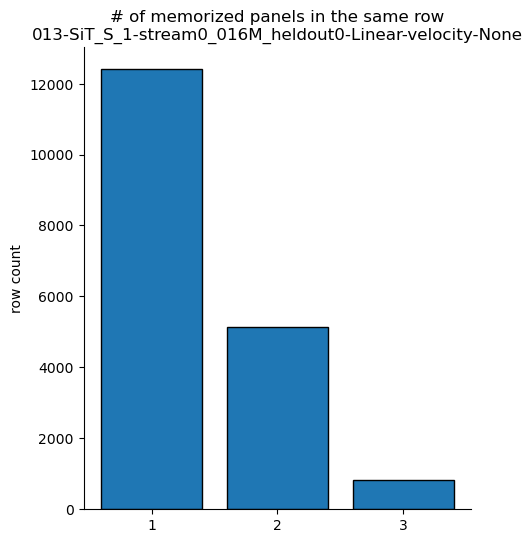

In [89]:
plt.figure(figsize=(5, 6))
plt.hist(mempan_cnt_in_row, bins=np.arange(4)+0.5, rwidth=0.8, align='mid', edgecolor='black')
plt.xticks(np.arange(1,4))
plt.ylabel("row count")
plt.title(f"# of memorized panels in the same row\n{expname}")
plt.show()

### (Controlled) Rule type separated memorization 

In [90]:
ctrl_sample_tsr_X_sm, ctrl_sample_tsr_y_sm = get_RAVEN_dataset(data_root, train_attr_fn, n_classes=40, cmb_per_class=500, heldout_ids=(), cmb_offset=40000)

In [91]:
_, ctrl_samp_panel_list = extract_panel_mat_set(ctrl_sample_tsr_X_sm, outtype=list)
pancnt, panfrac, idxlist = check_fraction_train_set_idxlist(ctrl_samp_panel_list, train_X_panel_set)
panel_total = len(ctrl_samp_panel_list)
sample_total = len(ctrl_sample_tsr_X_sm)
row_total = sample_total * 3
assert panel_total == sample_total * 9

In [92]:
row_label_y_vec = ctrl_sample_tsr_y_sm[:,None].repeat(1, 3,).reshape(-1)
row_label_y_vec.shape

torch.Size([60000])

In [94]:
(row_label_y_vec==1).sum()

tensor(1500)

In [95]:
# construct the binary vector and matrix of memorization
panel_mem_binary_vec = np.zeros((panel_total, ), dtype=bool)
panel_mem_binary_vec[idxlist] = True
panel_mem_bin_row_mat = panel_mem_binary_vec.reshape((row_total, 3))
panel_mem_bin_sample_mat = panel_mem_binary_vec.reshape((sample_total, 9))

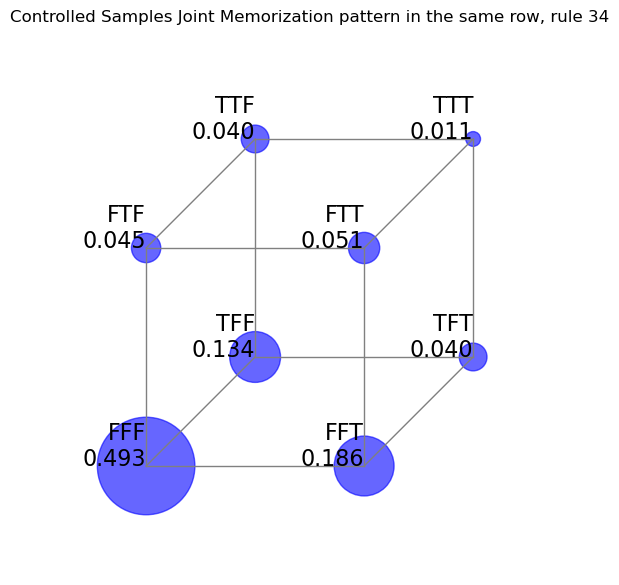

In [96]:
rule_id = 34
bin_pattern, counts = np.unique(panel_mem_bin_row_mat[(row_label_y_vec == rule_id), :], 
                                axis=0, return_counts=True) # the joint distribution of memorization in the same row. 
figh = plot_binary_patterns_with_connections(counts, binary_patterns=bin_pattern, text="freq")
figh.gca().set_title(f"Controlled Samples Joint Memorization pattern in the same row, rule {rule_id}")
figh.show()

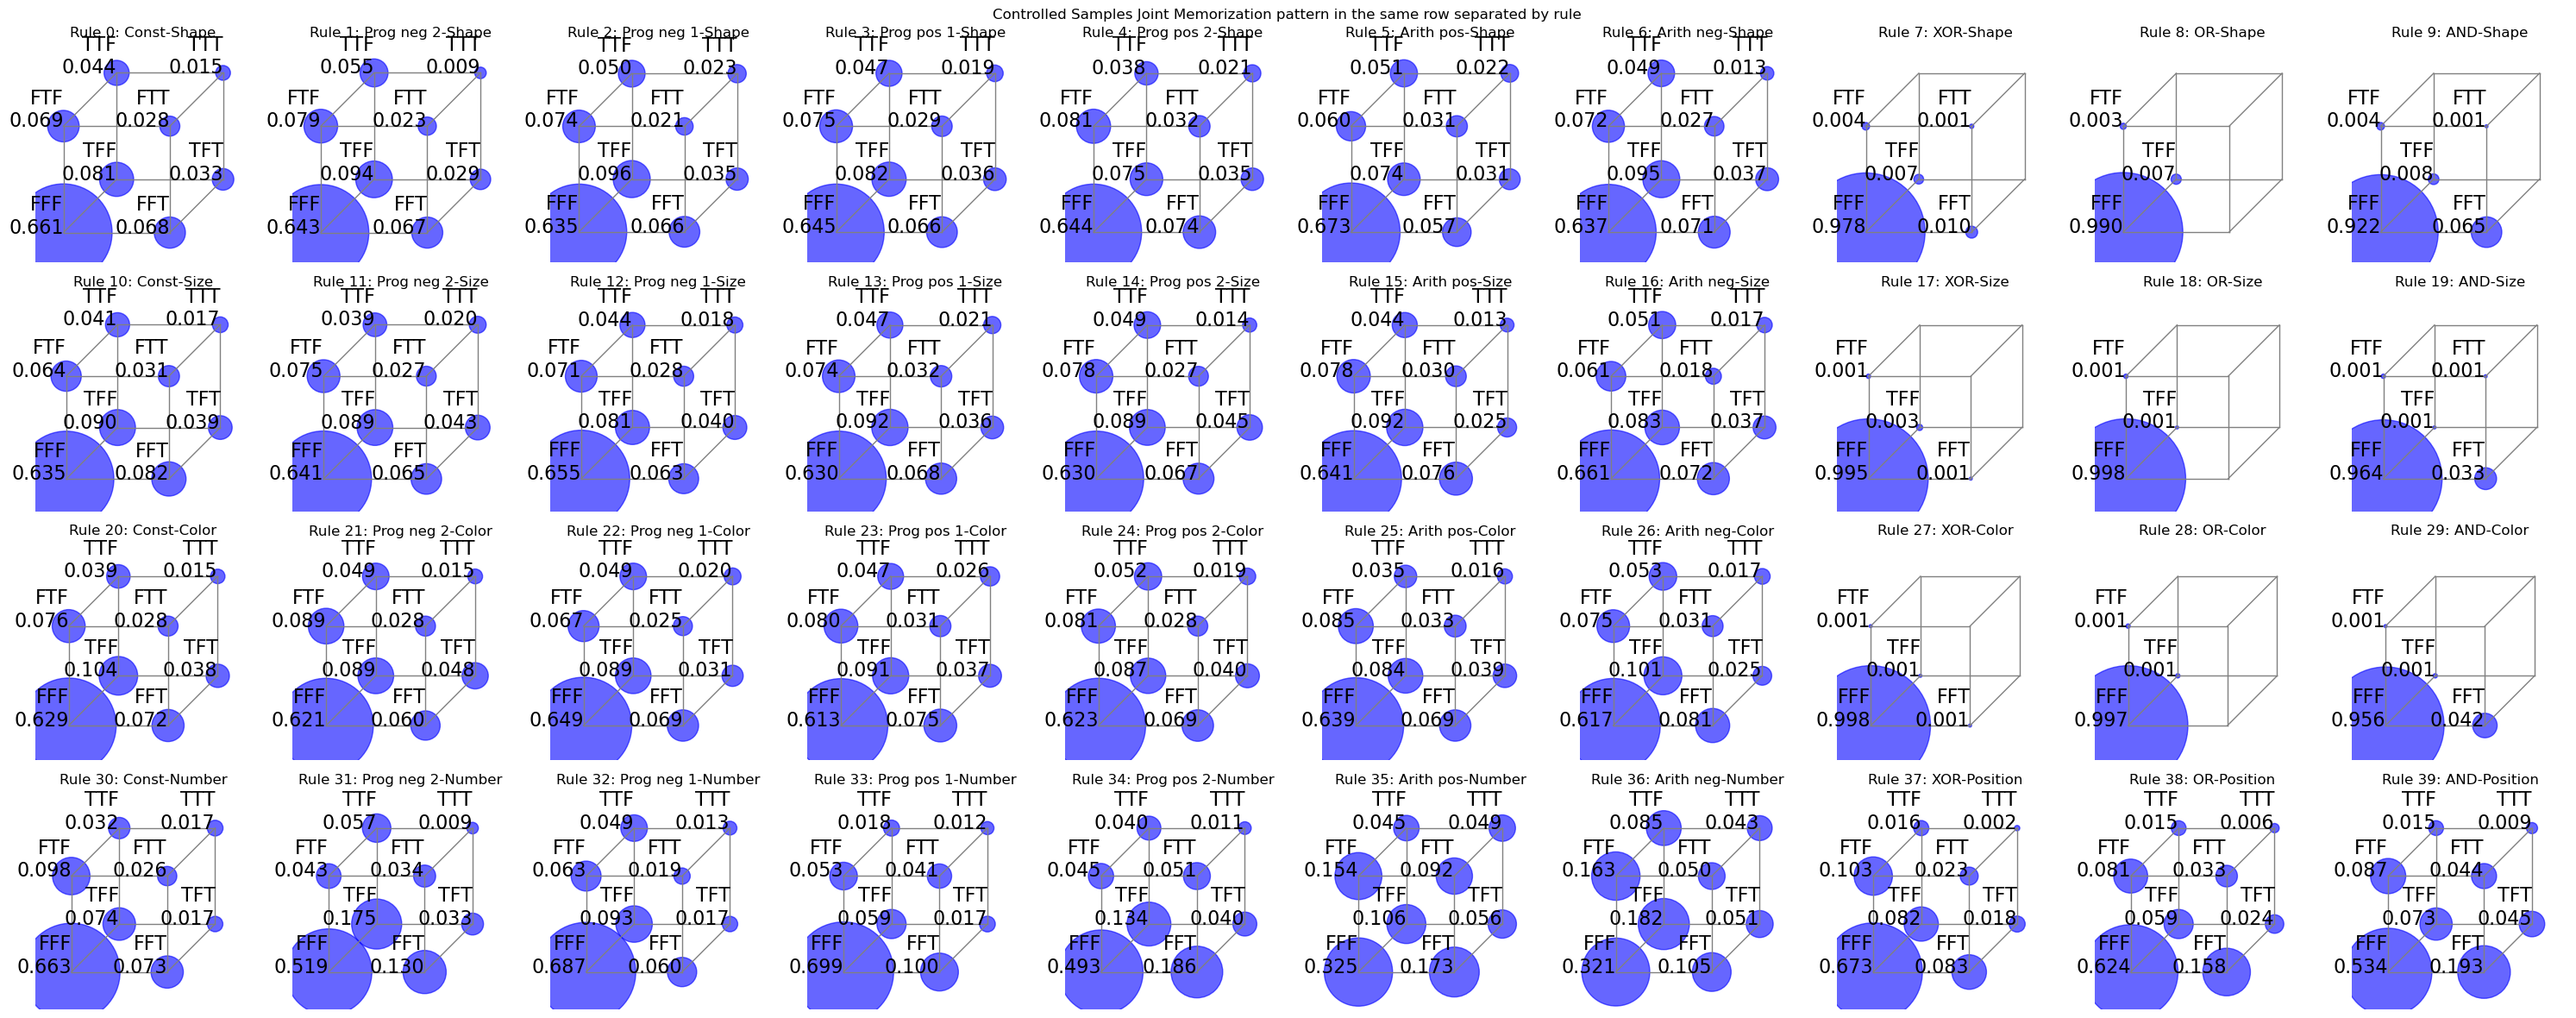

In [98]:
figh, axs = plt.subplots(4, 10, figsize=(30, 12))
axs = axs.flatten()
for rule_id in range(40):
    ax = axs[rule_id]
    bin_pattern, counts = np.unique(panel_mem_bin_row_mat[(row_label_y_vec == rule_id), :], 
                                    axis=0, return_counts=True) # the joint distribution of memorization in the same row. 
    plot_binary_patterns_with_connections(counts, binary_patterns=bin_pattern, text="freq", ax=ax)
    ax.set_title(f"Rule {rule_id}: {rule_table_brief[rule_id]}")
plt.suptitle("Controlled Samples Joint Memorization pattern in the same row separated by rule")
plt.tight_layout()
saveallforms(figexpdir, "control_memorization_row_joint_freq_rule_seperated", figh)
plt.show()

## Scratch

In [46]:
train_tsr_X_rows_attr0 = einops.rearrange(train_tsr_X[:, 0:1], 'B attr (R h) W -> (B R) (attr h W)', R=3, h=3, W=9).numpy().astype(int)
print(train_tsr_X_rows_attr0.shape)
train_X_rows_attr0_set = set([tuple(train_tsr_X_rows_attr0[i]) for i in range(train_tsr_X_rows_attr0.shape[0])])


(480000, 27)


In [47]:
gen_sample_rows_attr0 = einops.rearrange(sample_col[1000000][:, 0:1].round().int(), 'B attr (R h) W -> (B R) (attr h W)', R=3, h=3, W=9).numpy().astype(int)
gen_sample_rows_attr0_list = [tuple(gen_sample_rows_attr0[i]) for i in range(gen_sample_rows_attr0.shape[0])]
check_fraction_train_set(gen_sample_rows_attr0_list, train_X_rows_attr0_set)

(65, 0.010579427083333334)

In [44]:
mem_stats_col = []
for epoch in tqdm(sample_col.keys()):
    gen_sample_rows = einops.rearrange(sample_col[epoch].round().int(), 'B attr (R h) W -> (B R) (attr h W)', R=3, h=3, W=9).numpy().astype(int)
    gen_sample_rows_list = [tuple(gen_sample_rows[i]) for i in range(gen_sample_rows.shape[0])]
    cnt, frac = check_fraction_train_set(gen_sample_rows_list, train_X_row_set)
    mem_stats_col.append({"epoch": epoch, "cnt": cnt, "frac": frac})
rowmem_stats_df = pd.DataFrame(mem_stats_col)

  0%|          | 0/402 [00:00<?, ?it/s]

<Axes: xlabel='epoch'>

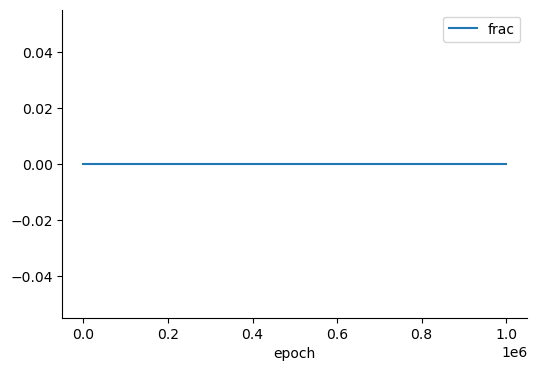

In [45]:
rowmem_stats_df.plot(x="epoch", y="frac", figsize=(6, 4))

In [39]:
mem_stats_col = []
for epoch in tqdm(sample_col.keys()):
    gen_sample_panels = einops.rearrange(sample_col[epoch].round().int(), 'B attr (R h) (P w) -> (B R P) (attr h w)', R=3, h=3, P=3, w=3).numpy().astype(int)
    gen_sample_panels_list = [tuple(gen_sample_panels[i]) for i in range(gen_sample_panels.shape[0])]
    cnt, frac = check_fraction_train_set(gen_sample_panels_list, train_X_panel_set)
    mem_stats_col.append({"epoch": epoch, "cnt": cnt, "frac": frac})
panmem_stats_df = pd.DataFrame(mem_stats_col)

  0%|          | 0/402 [00:00<?, ?it/s]

In [ ]:
mem_stats_col = []
for epoch in tqdm(sample_col.keys()):
    gen_sample_panels = einops.rearrange(sample_col[epoch].round().int(), 'B attr (R h) (P w) -> (B R P) (attr h w)', R=3, h=3, P=3, w=3).numpy().astype(int)
    gen_sample_panels_list = [tuple(gen_sample_panels[i]) for i in range(gen_sample_panels.shape[0])]
    cnt, frac = check_fraction_train_set(gen_sample_panels_list, train_X_panel_set)
    mem_stats_col.append({"epoch": epoch, "cnt": cnt, "frac": frac})
panmem_stats_df = pd.DataFrame(mem_stats_col)

<Axes: xlabel='epoch'>

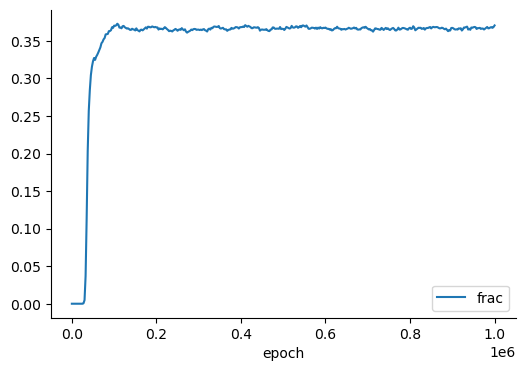

In [42]:
panmem_stats_df.plot(x="epoch", y="frac", figsize=(6, 4))

In [19]:
# for expfullname in syndf_SiT.full_name:
for expfullname in ["017-SiT_B_1-stream0_16M_heldout0-Linear-velocity-None/tensorboard_logs"]:
    tb_record = tb_data_col_SiT[expfullname]
    expname = expfullname.split("/tensorboard_logs")[0]
    prefix = "sample_rule_eval_" #"eval_step" if "stream" in expname else "eval_epoch"
    eval_col = sweep_collect_eval_data(expname, SiT_exproot, prefix=prefix)
    epoch_list, rule_list_all, consistency_all = extract_rule_list_from_eval_col_Diffusion(eval_col, )
    rule_cnt_mat, cons3_rule_cnt_mat, cons2_rule_cnt_mat = format_rule_list_to_mat(rule_list_all, consistency_all)

Extracted data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/SiT/results/017-SiT_B_1-stream0_16M_heldout0-Linear-velocity-None/samples
example file: 0155000.pt


  0%|          | 0/402 [00:00<?, ?it/s]

diffusion model, just fetch ab init generation
(402, 2048, 3) (402, 2, 2048)


In [21]:
type(eval_col)

dict

### plot all individual rule data

In [ ]:
for expfullname in syndf_SiT.full_name:
    tb_record = tb_data_col_SiT[expfullname]
    expname = expfullname.split("/tensorboard_logs")[0]
    prefix = "sample_rule_eval_" #"eval_step" if "stream" in expname else "eval_epoch"
    eval_col = sweep_collect_eval_data(expname, SiT_exproot, prefix=prefix)
    epoch_list, rule_list_all, consistency_all = extract_rule_list_from_eval_col_Diffusion(eval_col, )
    rule_cnt_mat, cons3_rule_cnt_mat, cons2_rule_cnt_mat = format_rule_list_to_mat(rule_list_all, consistency_all)
    eval_sample_num = rule_list_all.shape[1]
    print(expname)
    if "heldout0" in expname:
        heldout_id = [1, 16, 20, 34, 37]  
    else:
        heldout_id = []

    figh, axs = visualize_indiv_rule_dynam(epoch_list, rule_cnt_mat, conv_wid=10, heldout_id=heldout_id,
                            titlestr=f"{expname}\nValid rule count separated by rule type")
    saveallforms(SiTfigdir, f"{expname}_indiv_rule_validity", figh)

    figh, axs = visualize_indiv_rule_dynam(epoch_list, cons3_rule_cnt_mat, conv_wid=10, heldout_id=heldout_id,
                                        titlestr=f"{expname}\nConsistency 3 (blue) and 2 (orange) rule count", )
    figh, axs = visualize_indiv_rule_dynam(epoch_list, cons2_rule_cnt_mat, conv_wid=10, heldout_id=heldout_id,
                                        titlestr=f"{expname}\nConsistency 3 (blue) and 2 (orange) rule count", axs=axs)
    saveallforms(SiTfigdir, f"{expname}_indiv_rule_consistency", figh)
    
    figh = visualize_train_heldout_rule(epoch_list, rule_cnt_mat, heldout_id, 
                                normalizer=eval_sample_num * 3, reflevel=1 / 40,
                                titlestr=f"{expname}\nValid rule fraction")
    saveallforms(EDMfigdir, f"{expname}_train_held_rule_validity", figh)

    figh = visualize_train_heldout_rule(epoch_list, cons3_rule_cnt_mat, heldout_id, 
                                normalizer=eval_sample_num, reflevel=1 / 40,
                                titlestr=f"{expname}\nC3 sample fraction")
    saveallforms(SiTfigdir, f"{expname}_train_held_rule_consistency", figh)
    # raise ValueError("stop here")